# ***California Housing Price Prediction - EDA & Preprocessing***
***Nov 2025***

# 🔶Import Libraries

In [128]:
import numpy as np
import pandas as pd
from scipy.stats import skew, boxcox, yeojohnson

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import missingno as msno

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer # For Missing Value Handeling


# 🔶Data Overview

**🏠 California Housing Dataset**
| **Column Name**        | **Description**                                                                                                                                                                                                                          |
| ---------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **longitude**          | The geographical coordinate that specifies how far west or east a house block group is located (in degrees). Negative values indicate locations west of the prime meridian — all values are negative because California lies west of it. |
| **latitude**           | The geographical coordinate specifying how far north a house block group is located (in degrees).                                                                                                                                        |
| **housing_median_age** | The median age of houses (in years) within a block group — older areas have higher values.                                                                                                                                               |
| **total_rooms**        | The total number of rooms (of all types: bedrooms, kitchens, etc.) in all houses within a block group.                                                                                                                                   |
| **total_bedrooms**     | The total number of bedrooms in all houses within a block group. Used along with `total_rooms` to estimate average house size.                                                                                                           |
| **population**         | The total population living within a block group. Useful for understanding density and neighborhood characteristics.                                                                                                                     |
| **households**         | The total number of households (i.e., groups of people living together) in a block group.                                                                                                                                                |
| **median_income**      | The median income (in tens of thousands of USD) for households in a block group. For example, `8.3252` represents $83,252.                                                                                                               |
| **median_house_value** | The median house value (in USD) for households in a block group. This is the target variable (label) often used for regression tasks.                                                                                                    |
| **ocean_proximity**    | A categorical feature indicating the location of the block group relative to the ocean. Possible categories include:<br>• `NEAR BAY`<br>• `NEAR OCEAN`<br>• `INLAND`<br>• `ISLAND`<br>• `<1H OCEAN` (less than one hour to the ocean).   |


In [129]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/housing.csv')
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [130]:
print(f'Shape of the Dataset:{df.shape}')
pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.values,
    "missing_values": df.isnull().sum().values,
    "unique_values": df.nunique().values
    })

Shape of the Dataset:(20640, 10)


column    dtype  missing_values  unique_values
0           longitude  float64               0            844
1            latitude  float64               0            862
2  housing_median_age  float64               0             52
3         total_rooms  float64               0           5926
4      total_bedrooms  float64             207           1923
5          population  float64               0           3888
6          households  float64               0           1815
7       median_income  float64               0          12928
8  median_house_value  float64               0           3842
9     ocean_proximity   object               0              5

## ⮞Casting Object Data as Categorical Data

In [131]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')
df.dtypes

longitude              float64
latitude               float64
housing_median_age     float64
total_rooms            float64
total_bedrooms         float64
population             float64
households             float64
median_income          float64
median_house_value     float64
ocean_proximity       category
dtype: object

# 🔶Train-Test Split

median_income is the strongest predictor of house value. Therefore, a random split may cause income distribution leakage, because the test set may not represent the real-world distribution.
So we use Stratified train-test split based on income. This ensures the test set is statistically similar to the whole dataset.

In [132]:
# Create income categories
df["income_cat"] = pd.cut(
    df["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

In [133]:
# Test Size = 20%
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df["income_cat"]):
    train_set = df.loc[train_idx]
    test_set = df.loc[test_idx]

# Drop income-cat, it was only used for splitting
for set_ in (train_set, test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [134]:
print(f'Shape of Train Set: {train_set.shape}')
train_set.head()

Shape of Train Set: (16512, 10)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  median_house_value  \
13096      1576.0      1034.0         2.0987            458300.0   
14973       666.0       357.0         6.0876            483800.0   
3785        562.0       203.0         2.4330            101700.0   
14689      1845.0       780.0         2.2618             96100.0   
20507      1912.0      1172.0         3.5292            361800.0   

      ocean_proximity  
13096        NEAR BAY  
14973       <1H OCEAN  
3785           INLAND  
14689          INLAND  
20507      NEAR OCEAN

In [135]:
# The test set will be set aside until the final evaluation of the model
print(f'Shape of Test Set: {test_set.shape}')
test_set.head()

Shape of Test Set: (4128, 10)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3905     -121.95     37.11                21.0       2387.0           357.0   
16821    -118.01     33.89                36.0       1589.0           265.0   
2900     -118.18     33.74                30.0       5915.0          1750.0   
7193     -122.48     37.74                52.0       2166.0           423.0   
13928    -122.39     37.78                 5.0       1405.0           515.0   

       population  households  median_income  median_house_value  \
3905        913.0       341.0         7.7360            397700.0   
16821       804.0       272.0         4.6354            202900.0   
2900       2136.0      1503.0         4.0968            310000.0   
7193       1072.0       370.0         4.1310            314300.0   
13928       725.0       392.0         3.6037            187500.0   

      ocean_proximity  
3905        <1H OCEAN  
16821       <1H OCEAN  
2900       NEAR OCEAN  
7193       NEAR OCEAN  
13928        NEAR BAY

# 🔶Missing Values

<Axes: >

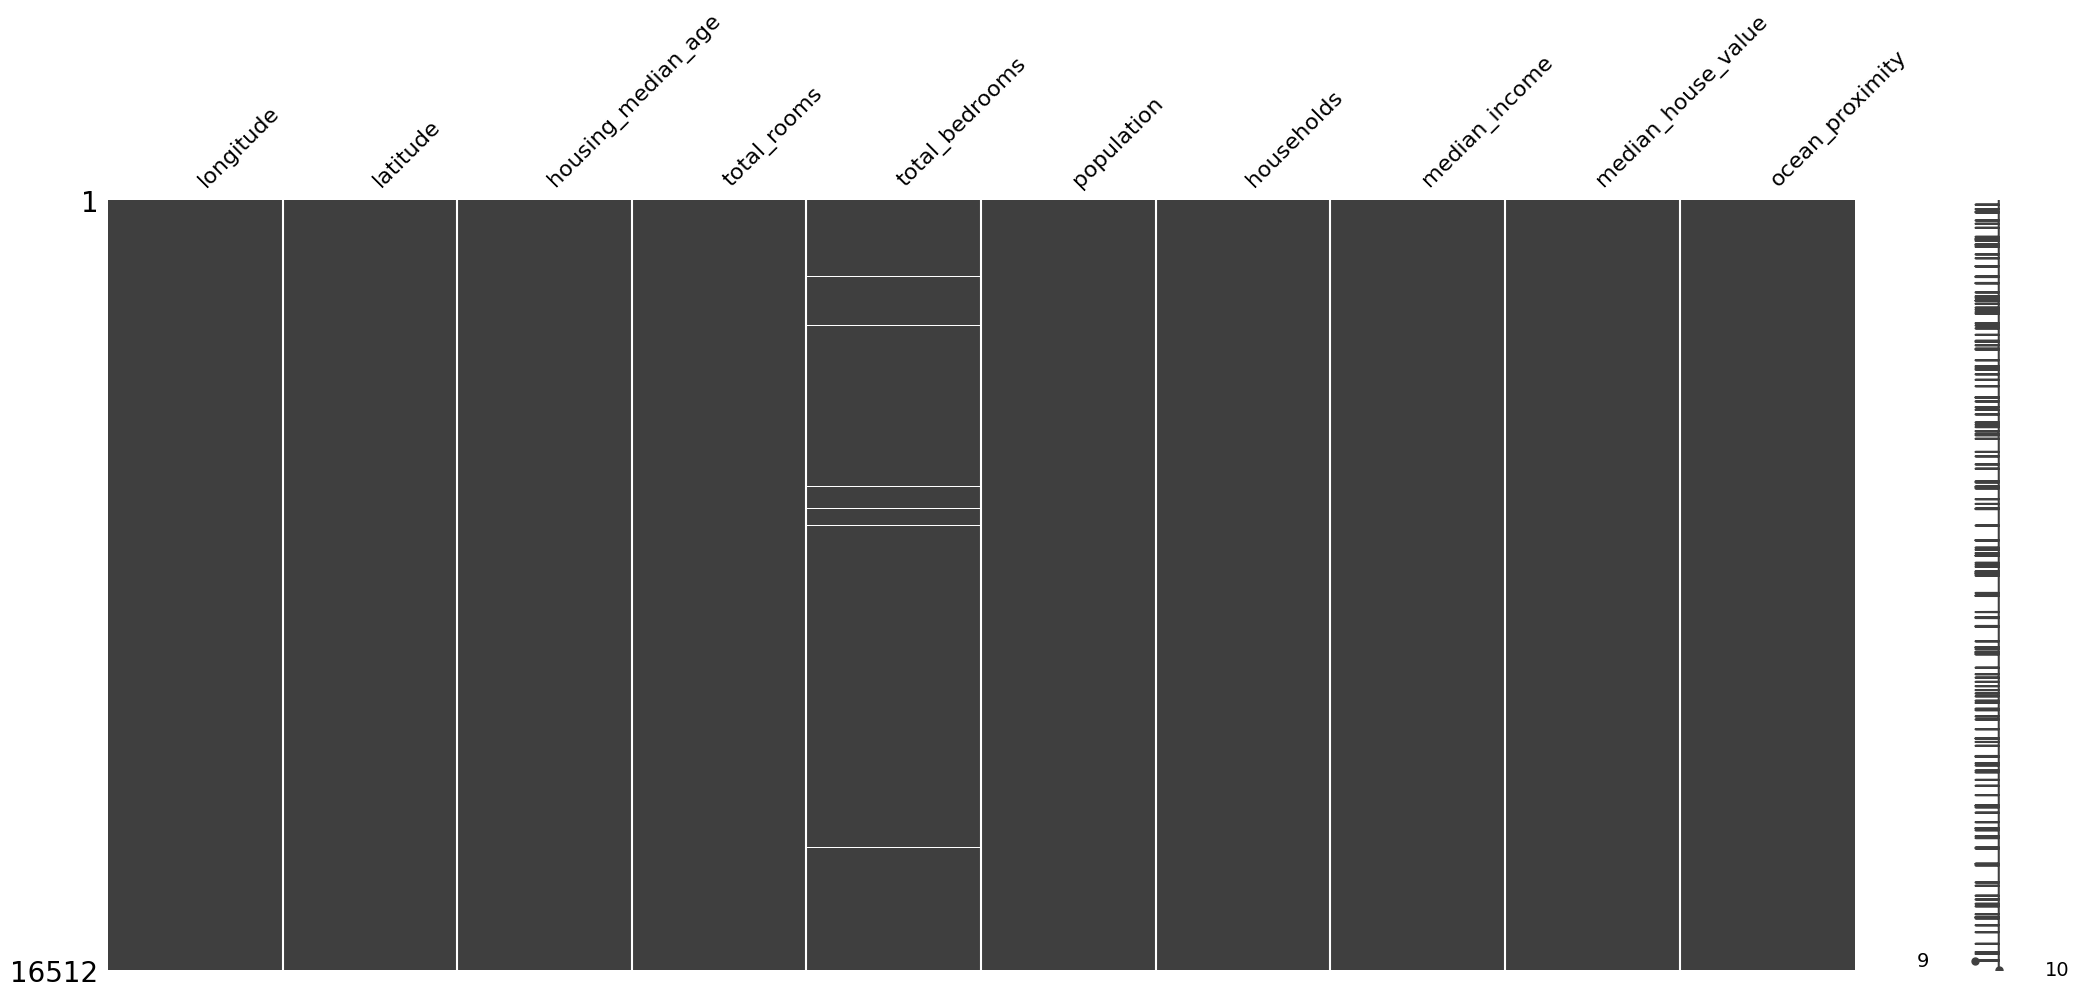

In [136]:
msno.matrix(train_set)

In [137]:
train_set.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

## ⮞Diagnose Missing Values

In [138]:
def mv_diagnose(df, col_to_check, bins=20):
  if col_to_check not in df.columns:
    raise ValueError(f'{col_to_check} Not in Dataframe')

  cols= [c for c in df.columns if c!= col_to_check] # exclude the col_to check from plotting
  flags= df[col_to_check].isna()

  fig, ax = plt.subplots(len(cols), 4,
                         figsize=(len(cols)*4, len(cols)*4),
                         constrained_layout=True)
  plt.rcParams['axes.grid'] = True
  plt.rcParams['grid.color'] = 'lightgray'     # lighter color
  plt.rcParams['grid.alpha'] = 0.3             # make lines more transparent
  plt.rcParams['grid.linestyle'] = '--'        # dashed
  plt.rcParams['grid.linewidth'] = 0.5         # thinner lines

  plt.suptitle(f"Effect of Missing Values of {col_to_check} on Other columns' Distribution",
               fontsize=14,
               weight='bold')
  titles = [
        'Before Removing MVs',
        'After Removing MVs',
        'Difference (|Before - After|)',
        'Before vs After'
    ]
  for j, t in enumerate(titles):
    ax[0, j].set_title(t, fontsize=10, weight='bold')

  for i,col in enumerate(cols):
    n1, bin_edges, _ = ax[i,0].hist(df[col], bins=bins)

    n2,_,_ = ax[i,1].hist(df[col][~flags], bins=bins)

    ax[i,2].bar(bin_edges[:-1], np.abs(n2-n1), width=np.diff(bin_edges), align='edge')

    ax[i,3].hist(df[col], bins=bins, label='Before')
    ax[i,3].hist(df[col][~flags], bins=bins, alpha=0.5, label='After')
    ax[i,3].legend()

    # Row title on the left side
    ax[i, 0].set_ylabel(col, rotation=0, labelpad=50, fontsize=12, weight='bold')

  plt.tight_layout()
  plt.show();


/tmp/ipython-input-162753294.py:43: UserWarning:

The figure layout has changed to tight



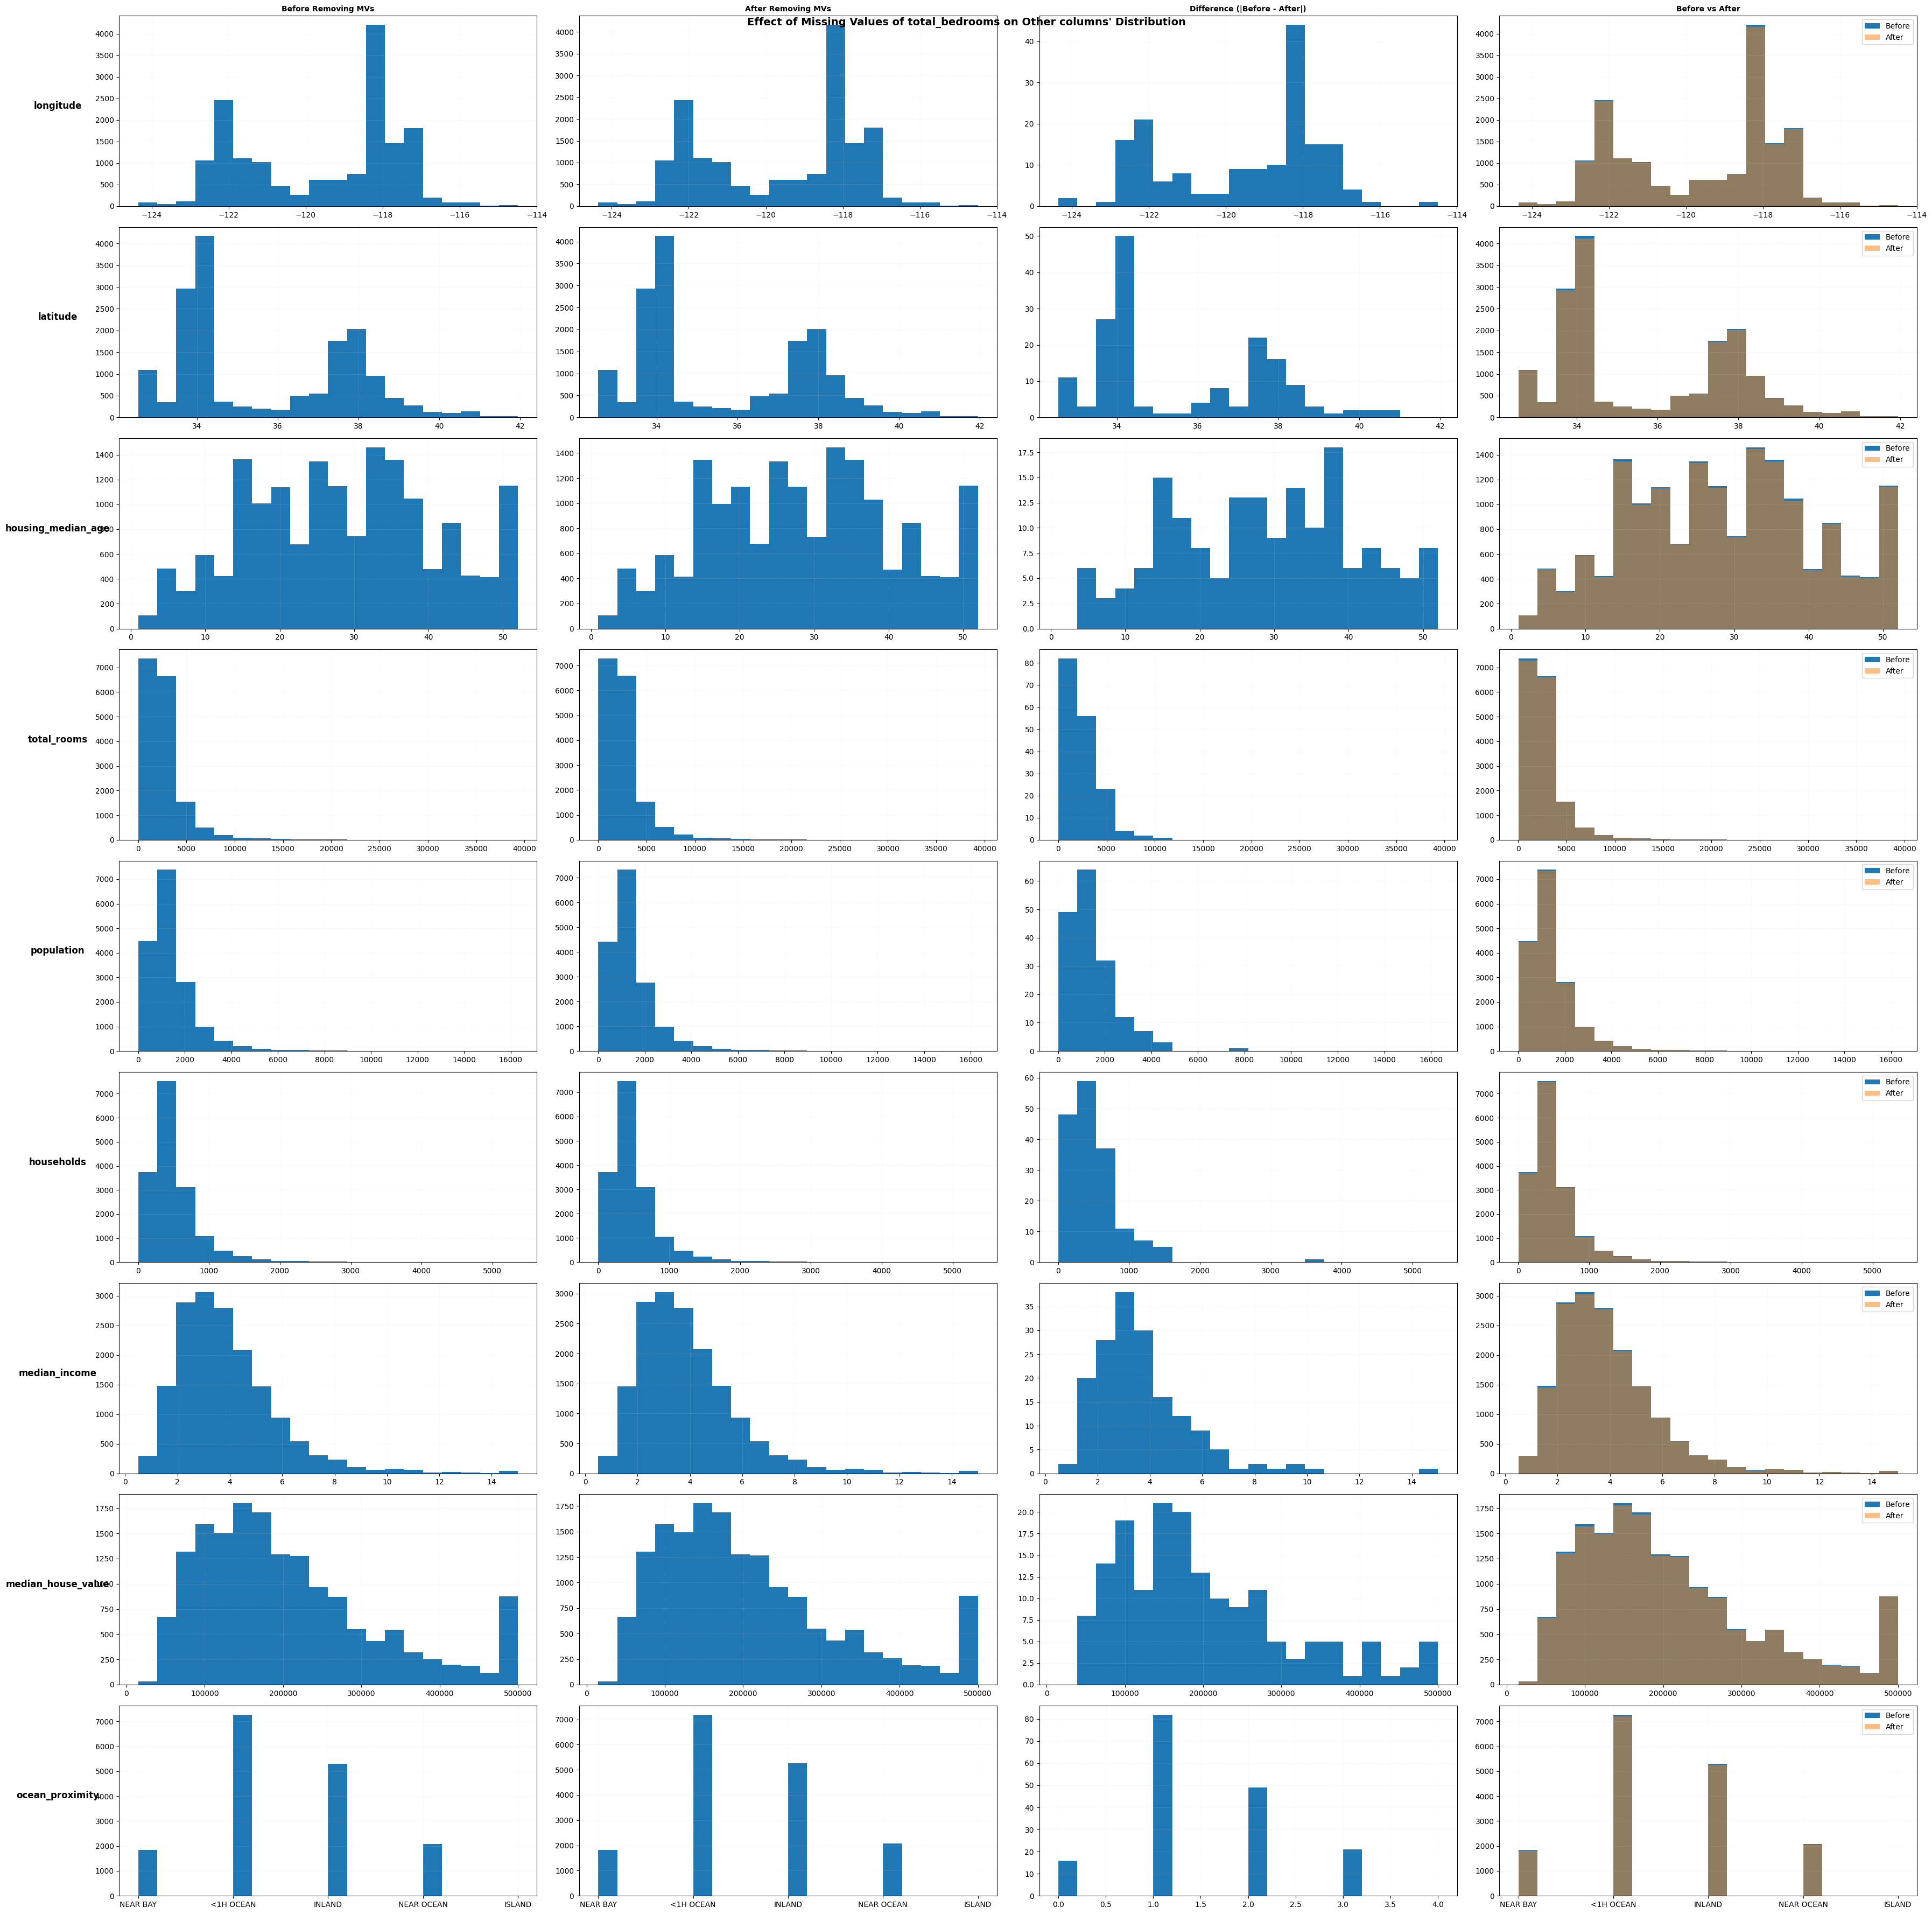

In [139]:
mv_diagnose(train_set, 'total_bedrooms')

As shown in the plots, the presence of missing values in "total_bedrooms" does not noticeably affect the distribution of other features. This suggests that the missing values occur completely at random and are not related to any observed variable. Therefore, the type of missingness in "total_bedrooms" can be classified as MCAR (Missing Completely At Random).

## ⮞Handeling Missing Values

In [140]:
print(f' mean={train_set['total_bedrooms'].mean()}\n median={train_set['total_bedrooms'].median()}\n mode={train_set['total_bedrooms'].mode()}')

 mean=538.9490944689182
 median=434.0
 mode=0    345.0
Name: total_bedrooms, dtype: float64


In [141]:
# Replacing the missing values in the train_set with the median of the column:
train_median = train_set['total_bedrooms'].median()

train_set.fillna({'total_bedrooms' : train_median}, inplace=True)
train_set['total_bedrooms'].isna().sum()

np.int64(0)

In [142]:
# Alternative method for missing value handeling using sklearn imputer
"""
imputer = SimpleImputer(strategy='median')

cols = train_set.select_dtypes('float64').columns   # Imputer won't work with non-numeric columns
imputer.fit_transform(train_set[cols])
imputer.statistics_, m

imputer.transform(test_set)
"""

"\nimputer = SimpleImputer(strategy='median')\n\ncols = train_set.select_dtypes('float64').columns   # Imputer won't work with non-numeric columns\nimputer.fit_transform(train_set[cols])\nimputer.statistics_, m\n\nimputer.transform(test_set)\n"

# 🔶Encoding Categorical Features

In [143]:
train_set.ocean_proximity.unique()

['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']
Categories (5, object): ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

## ⮞One-Hot Encoding

In [144]:
train_set = pd.get_dummies(train_set, columns=['ocean_proximity'], dtype=np.float64)
train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  median_house_value  \
13096      1576.0      1034.0         2.0987            458300.0   
14973       666.0       357.0         6.0876            483800.0   
3785        562.0       203.0         2.4330            101700.0   
14689      1845.0       780.0         2.2618             96100.0   
20507      1912.0      1172.0         3.5292            361800.0   

       ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
13096                        0.0                     0.0   
14973                        1.0                     0.0   
3785                         0.0                     1.0   
14689                        0.0                     1.0   
20507                        0.0                     0.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
13096                     0.0                       1.0   
14973                     0.0                       0.0   
3785                      0.0                       0.0   
14689                     0.0                       0.0   
20507                     0.0                       0.0   

       ocean_proximity_NEAR OCEAN  
13096                         0.0  
14973                         0.0  
3785                          0.0  
14689                         0.0  
20507                         1.0

## ⮞Creating More Codeable Column Name in the Train Set

In [145]:
# Lower case, No space
train_set.rename(columns={'ocean_proximity_<1H OCEAN' : 'ocean_proximity_1h_ocean',
                          'ocean_proximity_INLAND' :'ocean_proximity_inland',
                          'ocean_proximity_ISLAND' : 'ocean_proximity_island',
                          'ocean_proximity_NEAR BAY' : 'ocean_proximity_near_bay',
                          'ocean_proximity_NEAR OCEAN' : 'ocean_proximity_near_ocean'},
                 inplace=True)

In [146]:
train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  median_house_value  \
13096      1576.0      1034.0         2.0987            458300.0   
14973       666.0       357.0         6.0876            483800.0   
3785        562.0       203.0         2.4330            101700.0   
14689      1845.0       780.0         2.2618             96100.0   
20507      1912.0      1172.0         3.5292            361800.0   

       ocean_proximity_1h_ocean  ocean_proximity_inland  \
13096                       0.0                     0.0   
14973                       1.0                     0.0   
3785                        0.0                     1.0   
14689                       0.0                     1.0   
20507                       0.0                     0.0   

       ocean_proximity_island  ocean_proximity_near_bay  \
13096                     0.0                       1.0   
14973                     0.0                       0.0   
3785                      0.0                       0.0   
14689                     0.0                       0.0   
20507                     0.0                       0.0   

       ocean_proximity_near_ocean  
13096                         0.0  
14973                         0.0  
3785                          0.0  
14689                         0.0  
20507                         1.0

# 🔶Exploratory Data Analysis (EDA)

## ⮞Univariate Analysis

### ▸Histograms


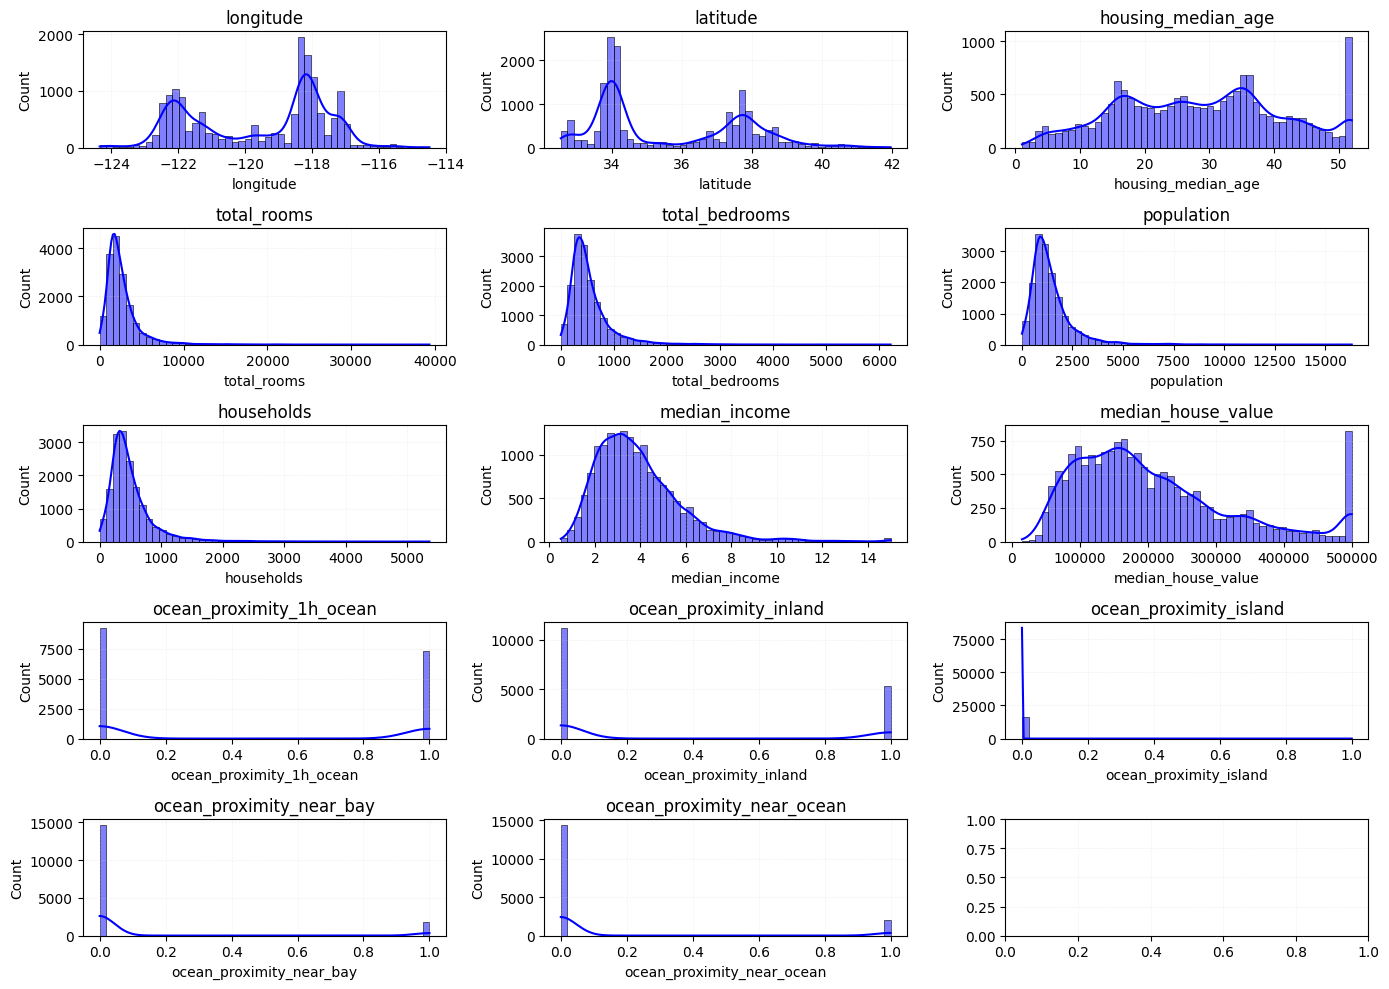

In [147]:
fig , axes = plt.subplots(5,3, figsize=(14,10))
flatten_ax = axes.flatten()

for i, col in enumerate(train_set.columns):
  ax = flatten_ax[i]
  #ax.hist(train_set[col],50)
  #ax.set_title(col)
  sns.histplot(train_set[col], bins=50, kde=True,color='b', ax=ax)
  ax.set_title(col)
plt.tight_layout()

**📊 Interpretation of Histograms:**

* Longitude & Latitude:
These two features show two distinct peaks, suggesting that the data may be a combination of two Gaussian-like distributions. Further analysis is needed to understand the reason behind this pattern.
* Housing Median Age:
This feature displays three noticeable peaks, indicating that multiple sub-distributions might be overlapping. Further investigation is required to identify what causes these clusters.
* Total Rooms, Total Bedrooms, Population, and Households:
These features exhibit similar behavior, showing approximately Gaussian shapes with right-skewed distributions. This skewness suggests the potential presence of outliers or areas with unusually high values.
* Median Income:
The distribution is right-skewed, resembling a Gaussian shape but with a longer tail toward higher income values.
* Median House Value:
This feature also has a right-skewed Gaussian shape, but there is a distinct bar at the upper end of the distribution that deviates from the overall trend. This anomaly might indicate the presence of outliers or a capped maximum value in the dataset.
* Ocean Proximity:
Due to the encoding process, this categorical feature was transformed into five binary variables. Most data points correspond to locations within one hour's distance from the ocean, while entries representing islands are extremely limited and close to zero in frequency.

### ▸Box Plots

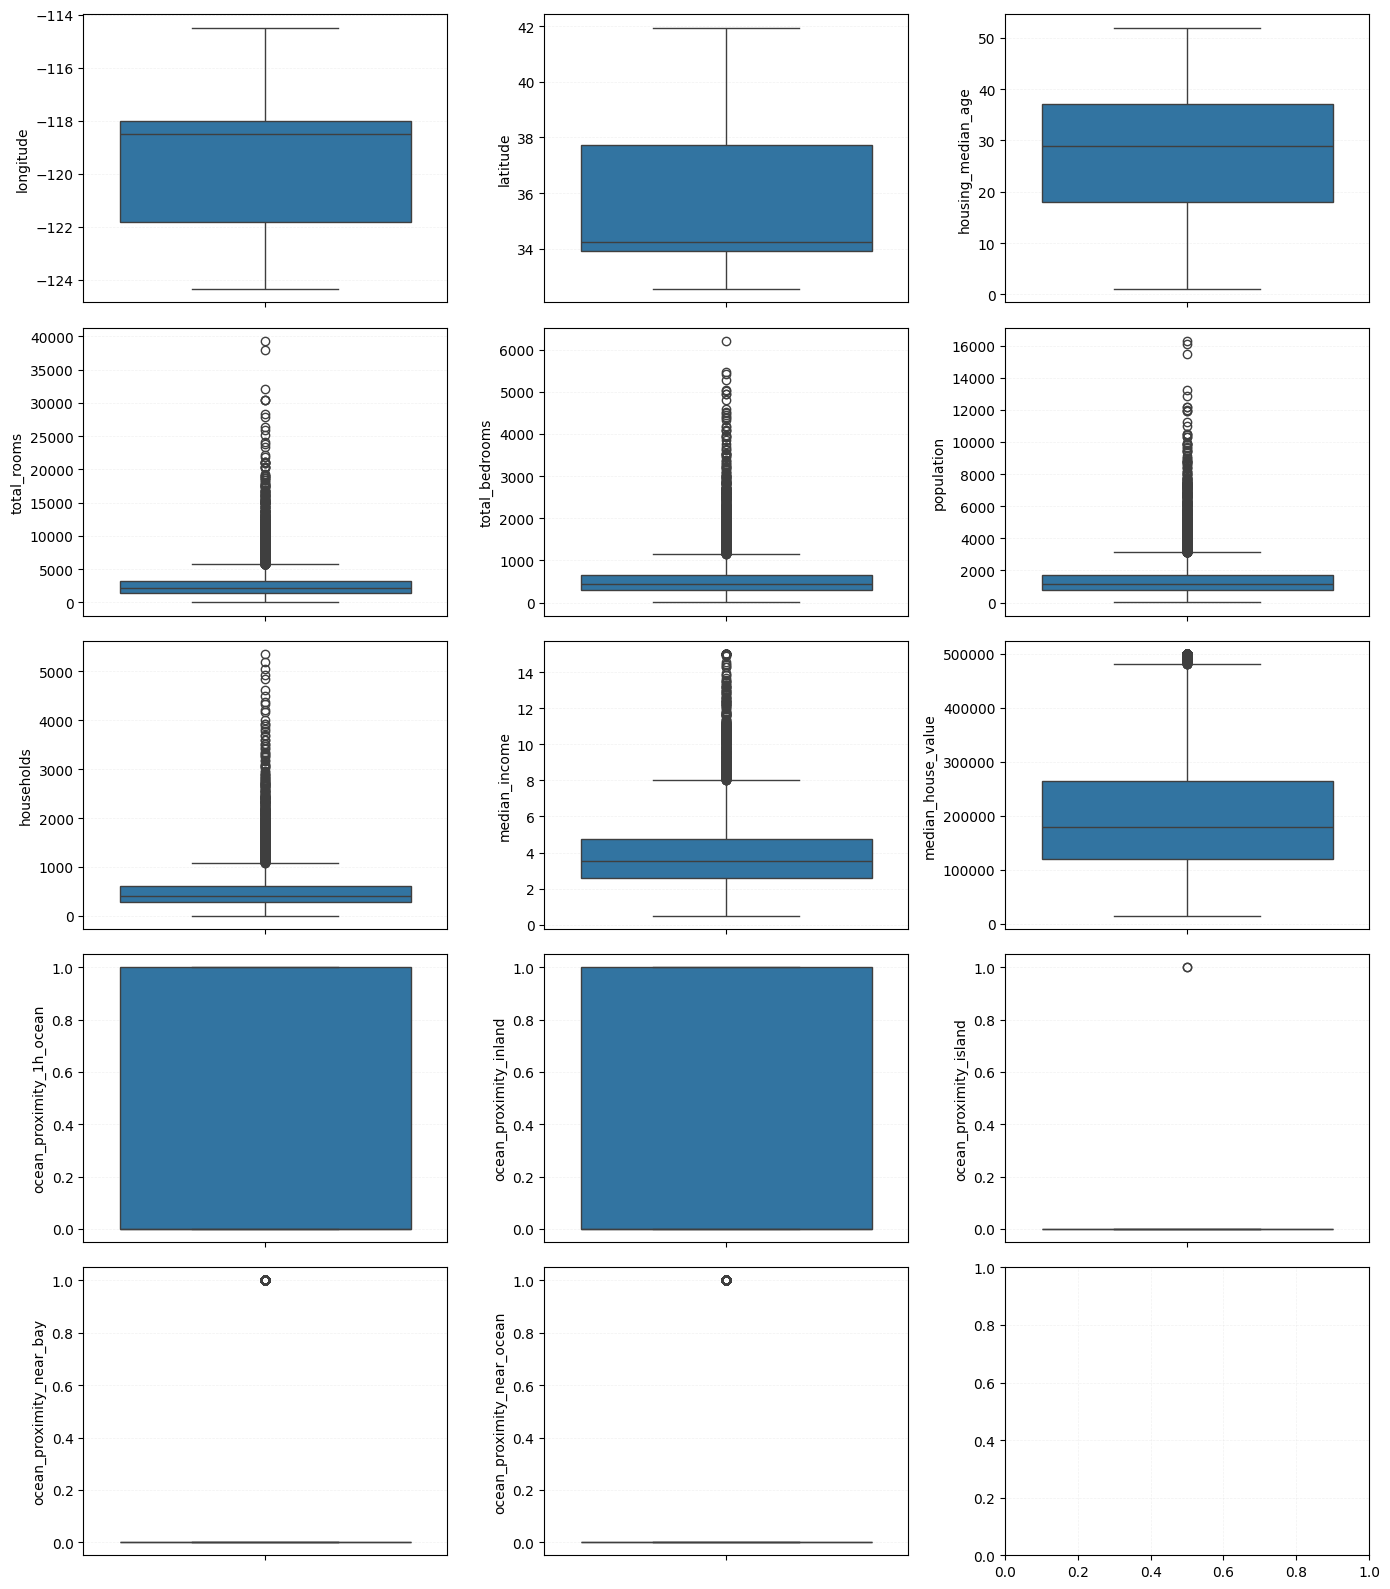

In [148]:
fig , axes = plt.subplots(5,3, figsize=(14,16))
flatten_ax = axes.flatten()

for i, col in enumerate(train_set.columns):
  ax = flatten_ax[i]
  #ax.boxplot(train_set[col])
  #ax.set_title(col)
  sns.boxplot(train_set[col], ax=ax)
plt.tight_layout()
plt.show()

**📊 Interpretation of Boxplots:**

As observed in the box plots, the features that showed a strong right skew in the histograms ( Total Rooms, Total Bedrooms, Population, Households, Median Income, and Median House Value) also display numerous outliers on the upper side of their distributions.

## ⮞Bivariate Analysis

### ▸Correlations

<Axes: >

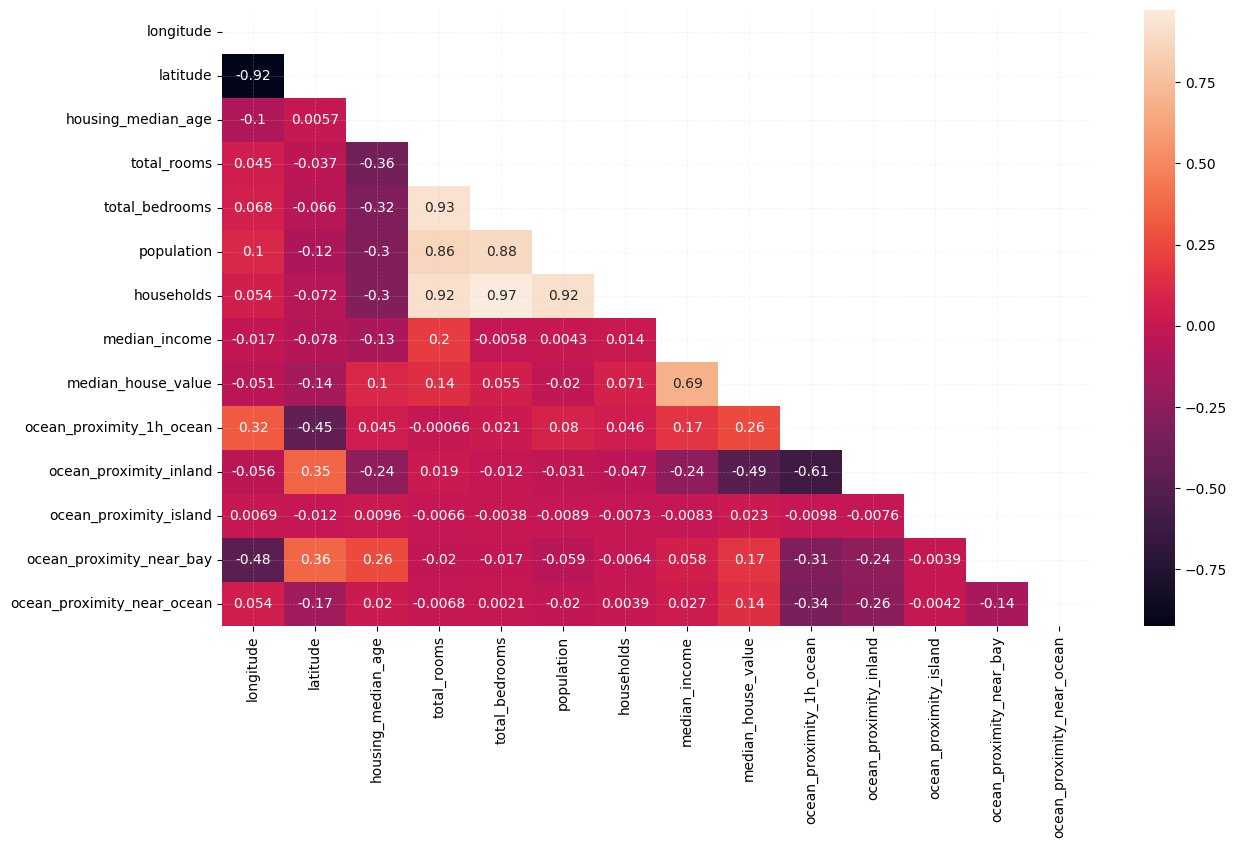

In [149]:
plt.figure(figsize=(14,8))
corr = train_set.corr()
sns.heatmap(corr, annot=True, mask=np.triu(corr))

In [150]:
corr[['median_house_value']].abs().sort_values(by='median_house_value')

median_house_value
population                            0.020153
ocean_proximity_island                0.023258
longitude                             0.050859
total_bedrooms                        0.054530
households                            0.071426
housing_median_age                    0.102175
total_rooms                           0.137455
ocean_proximity_near_ocean            0.138747
latitude                              0.139584
ocean_proximity_near_bay              0.166398
ocean_proximity_1h_ocean              0.257132
ocean_proximity_inland                0.485070
median_income                         0.688380
median_house_value                    1.000000

### ▸Scatter Plots

In [151]:
# Pair Plot
sns.pairplot(train_set)

Output hidden; open in https://colab.research.google.com to view.

In [152]:

def scatter_plot(col1, col2):
  plt.scatter(train_set[col1], train_set[col2], alpha=0.4)
  plt.title(f'{col1} Vs. {col2}')
  plt.xlabel(col1)
  plt.ylabel(col2)
  plt.tight_layout()
  plt.show()

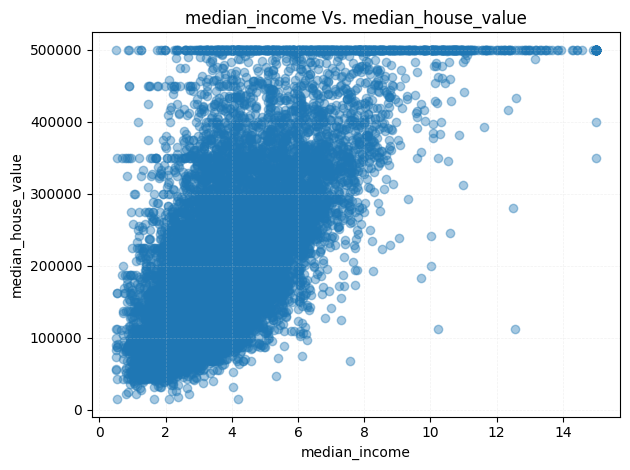

In [153]:
# Scatter plot of median income Vs. median house value
scatter_plot('median_income','median_house_value')

There are some horizontal shapes in this scatter plot that need further investigation.
The top horizontal band indicates a capped target value ($500,000 limit)

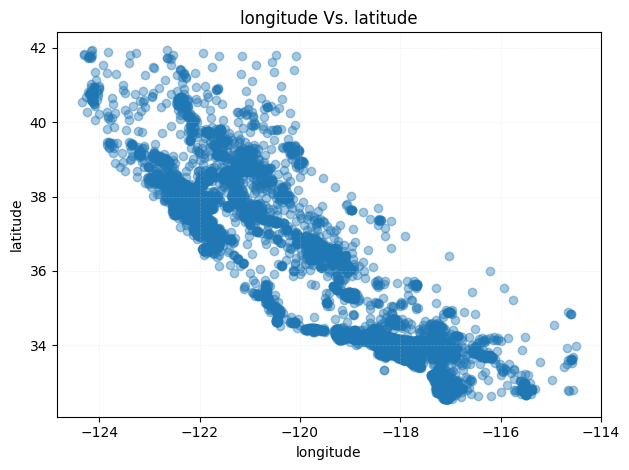

In [154]:
# Scatter plot of longitude Vs. latitude
scatter_plot('longitude', 'latitude')

In [155]:
# Scatter plot of longitude Vs. latitude on the California map
fig = px.scatter_mapbox(
    train_set,
    lat="latitude",
    lon="longitude",
    zoom=5,
    mapbox_style="open-street-map",
    title="California Housing Data Map"
)

# Change figure size
fig.update_layout(height=800, width=800)
fig.show()


In the simple scatter plot, we can observe that some regions have a higher density of data points, indicating more housing units in those areas. When we overlay the points on the map background, it becomes clear that these dense clusters correspond to regions near the coastline and other bodies of water. This suggests that proximity to water is a key factor in the distribution of housing in California, which may also influence housing prices.

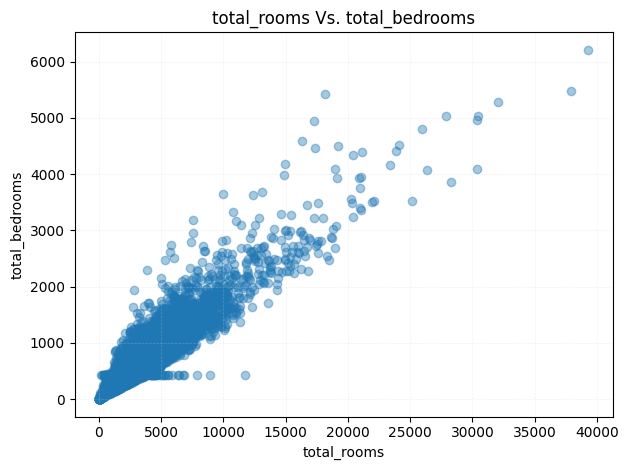

In [156]:
# scatter plot of total rooms Vs. total bedrooms
scatter_plot('total_rooms', 'total_bedrooms')

Total bedrooms and total rooms exhibit a strong positive correlation, indicating that houses with more rooms generally have more bedrooms. However, the scatter plot shows that data becomes sparse for houses with total bedrooms over 3,000 or total rooms over 20,000, with the majority of the data concentrated at lower values. This suggests that extremely large houses are rare in the dataset and may be considered outliers.

### ▸Box & Violin Plots

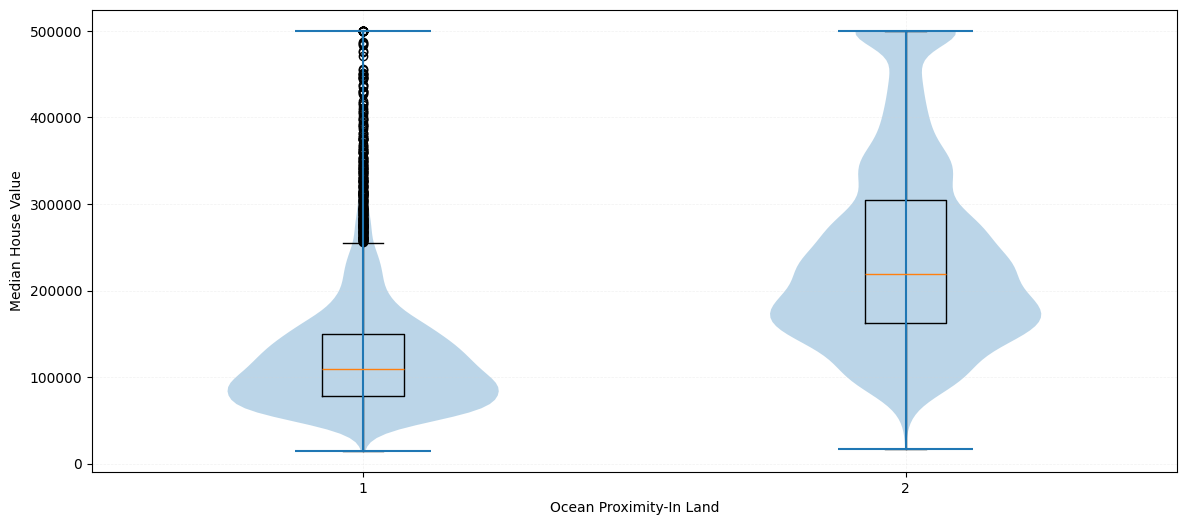

In [157]:
# median house value for in land Vs. non-in land ocean proximity category
flags = train_set.ocean_proximity_inland.astype(np.bool_)

plt.figure(figsize=(14,6))
plt.boxplot([train_set.median_house_value[flags], train_set.median_house_value[~flags]])
plt.violinplot([train_set.median_house_value[flags], train_set.median_house_value[~flags]])
plt.xlabel('Ocean Proximity-In Land')
plt.ylabel('Median House Value')
plt.show();

The inland houses (left violin plot, median around 100,000) generally have lower median house values compared to houses in non-inland areas (right violin plot, median around $220,000). This suggests that proximity to the ocean is associated with higher housing prices in California.


/tmp/ipython-input-3938638045.py:5: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



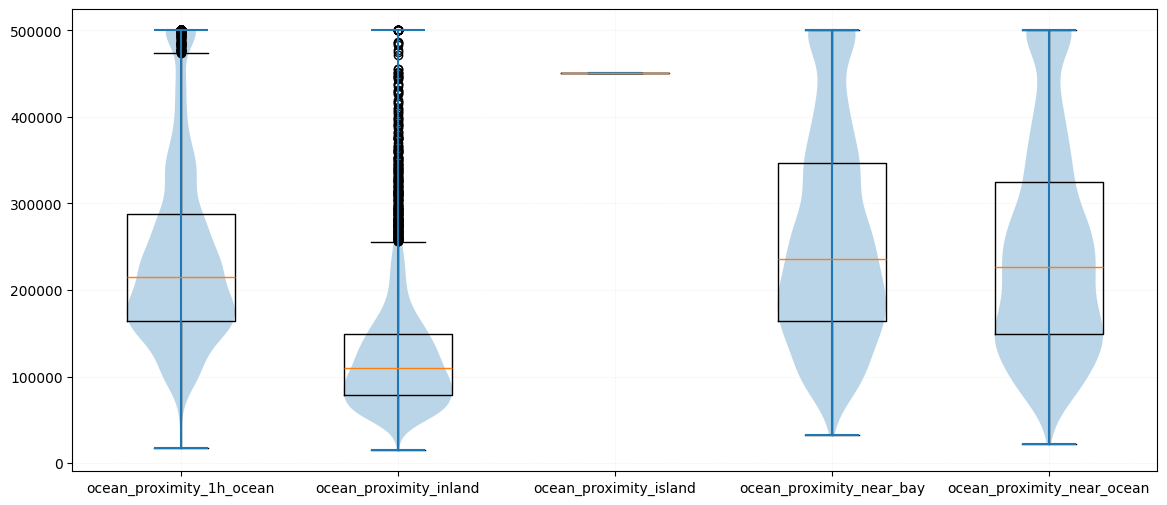

In [158]:
# median house value for different ocean proximity categories
ocean_cats = train_set.columns[9:]

plt.figure(figsize=(14,6))
plt.boxplot([train_set.median_house_value[train_set[cat]==1] for cat in ocean_cats], labels = ocean_cats)
plt.violinplot([train_set.median_house_value[train_set[cat]==1] for cat in ocean_cats]);

The ocean_proximity_near_bay and ocean_proximity_near_ocean categories show almost identical behavior in terms of median house values. The ocean_proximity_1h_ocean category behaves similarly to these two, though slightly lower. In contrast, houses in the ocean_proximity_inland category have noticeably lower median values and exhibit a large number of outliers. This indicates that proximity to the ocean is strongly associated with higher housing prices, while inland locations generally correspond to more affordable homes with greater variability.

/tmp/ipython-input-1051980960.py:5: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



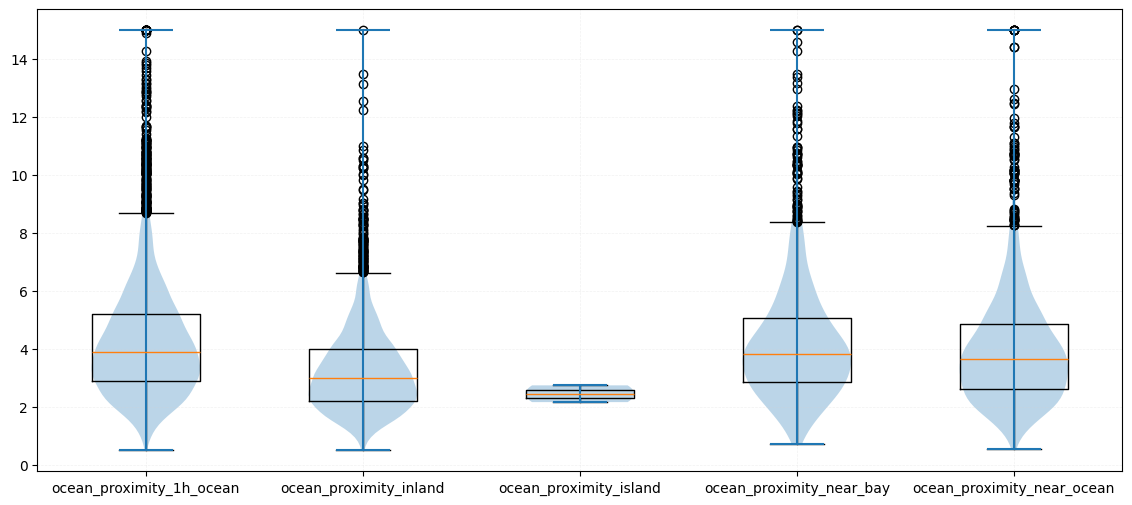

In [159]:
# median income for different ocean proximity categories
ocean_cats = train_set.columns[9:]

plt.figure(figsize=(14,6))
plt.boxplot([train_set.median_income[train_set[cat]==1] for cat in ocean_cats], labels = ocean_cats)
plt.violinplot([train_set.median_income[train_set[cat]==1] for cat in ocean_cats]);

After examining the distribution of median house values across different ocean proximity categories, it is also insightful to analyze the median income behavior, since this feature is strongly correlated with the target variable (median house value).

Interestingly, although houses located on islands are significantly more expensive than those in other categories, the median income for this group is actually lower. This contradicts the expected trend, where higher house prices typically align with higher household incomes.

However, this anomaly is likely due to the very small sample size of the ISLAND category (only about five data points). Because of this limited representation, its correlation with the target variable is close to zero and its behavior appears inconsistent with the rest of the data.

Therefore, it may be reasonable to consider removing the ISLAND category from further analysis.

## ⮞Multivariate Analysis

### ▸Geographical Analysis

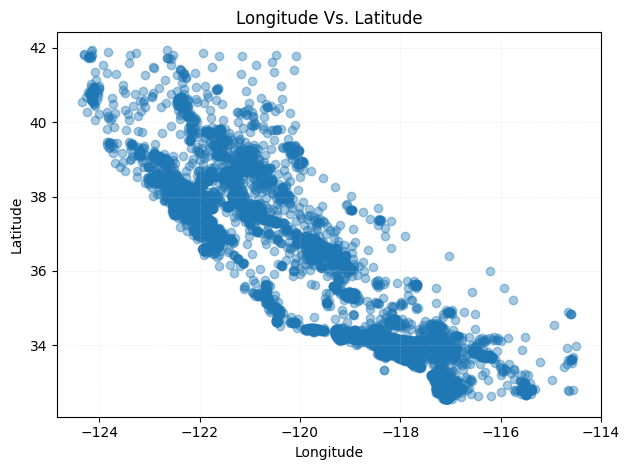

In [160]:
# Visualizing geographic data - Scatter plot of longitude & latitude
plt.scatter(train_set.longitude, train_set.latitude, alpha=0.4)
plt.title('Longitude Vs. Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

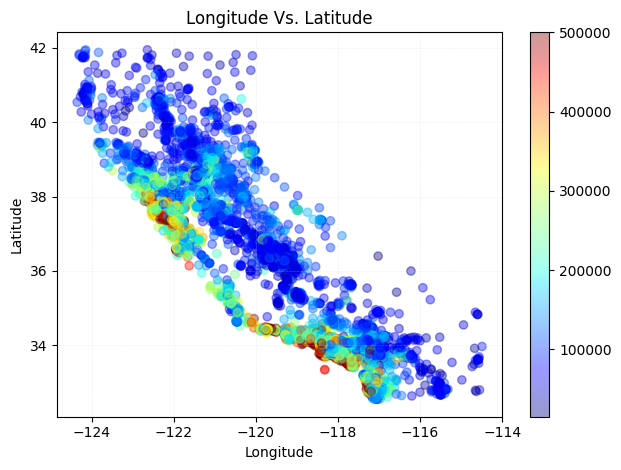

In [161]:
# Visualizing geographic data with color encoding - Scatter plot of longitude & latitude with median house value
plt.scatter(train_set.longitude, train_set.latitude,
            c=train_set.median_house_value.values, cmap='jet',
            alpha=0.4)
plt.title('Longitude Vs. Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.tight_layout()
plt.show()

By adding median house value as a color dimension to the longitude–latitude scatter plot, a clear spatial pattern emerges:
Houses located closer to the ocean tend to have higher prices, while property values decrease progressively as we move farther inland.

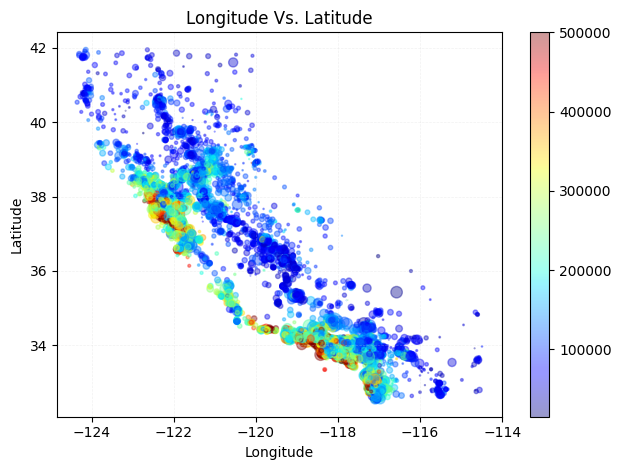

In [162]:
# Visualizing geographic data with color and size encoding - Scatter plot of longitude & latitude with median house value and population
plt.scatter(train_set.longitude, train_set.latitude,
            c=train_set.median_house_value.values, cmap='jet',
            s=train_set.population/100,
            alpha=0.4)
plt.title('Longitude Vs. Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.tight_layout()
plt.show()

In this scatter plot, the size of each data point represents population — larger points indicate areas with higher population, while smaller points represent less populated regions.
From the visualization, there appears to be no clear relationship between geographical location and population density, suggesting that population is relatively evenly distributed across different regions of California.

In [163]:
# Visualizing geographic data with color & size encoding and base map - Scatter plot of longitude & latitude with median house value and population
fig = px.scatter_mapbox(
    train_set,
    lat="latitude",
    lon="longitude",
    color="median_house_value",
    size="population",
    zoom=5,
    mapbox_style="open-street-map",
    title="California Housing Data Map"
)

# Change figure size
fig.update_layout(height=800, width=800)
fig.show()


In [164]:
# Visualizing geographic data with color & size encoding and base map - Scatter plot of long & lat with median-house-value and population across all ocean-proximity categories

# categories are the one-hot encoded ocean-proximity columns (from col index 9 onward)
categories = train_set.columns[9:].tolist()
assert len(categories) == 5, "Expecting 5 one-hot ocean-proximity columns from column index 9 onward."

# global color scale bounds (so colors are comparable across subplots)
vmin = train_set['median_house_value'].min()
vmax = train_set['median_house_value'].max()

# choose a sizeref so marker sizes are reasonable across plots
pop_max = train_set['population'].max()
# sizeref formula: 2.*max(pop)/(desired_max_marker_size**2)
desired_max_marker_size = 40
sizeref = 2.0 * pop_max / (desired_max_marker_size ** 2 + 1e-9)

# create 1x5 mapbox subplots
fig = make_subplots(
    rows=1, cols=5,
    specs=[[{"type": "mapbox"}]*5],
    subplot_titles=categories
)

# center & zoom for each small map (keep same center and zoom for comparability)
center = {"lat": train_set['latitude'].mean(), "lon": train_set['longitude'].mean()}
zoom_level = 5

for i, cat in enumerate(categories):
    subset = train_set[train_set[cat] == 1]
    # if a category has no rows, create an empty trace to keep layout consistent
    lats = subset['latitude'] if not subset.empty else []
    lons = subset['longitude'] if not subset.empty else []
    pops = subset['population'] if not subset.empty else []
    vals = subset['median_house_value'] if not subset.empty else []

    trace = go.Scattermapbox(
        lat=lats,
        lon=lons,
        mode='markers',
        marker=dict(
            size=pops.clip(lower=1),        # avoid zero-size markers
            sizemode='area',
            sizeref=sizeref,
            sizemin=2,
            color=vals,
            colorscale='jet',
            cmin=vmin,
            cmax=vmax,
            opacity=0.7,
            showscale=(i == 0),             # show colorbar only on first subplot
            colorbar=dict(title='Median\nHouse Value') if i == 0 else None
        ),
        name=str(cat),
        hoverinfo='text',
        hovertext=(subset[['median_house_value','median_income','population']].astype(str)
                   .agg(', '.join, axis=1)) if not subset.empty else None
    )

    # add trace into the (1, i+1) subplot
    fig.add_trace(trace, row=1, col=i+1)

    # set each subplot's mapbox settings (mapbox for first subplot, mapbox2 for second, ...)
    mapbox_key = 'mapbox' if i == 0 else f'mapbox{i+1}'
    fig.update_layout(**{
        mapbox_key: dict(
            style='open-street-map',
            center=center,
            zoom=zoom_level,
            bearing=0,
            pitch=0
        )
    })

# layout sizing & title
fig.update_layout(
    height=600,
    width=2000,
    title_text="Median House Value (color) & Population (size) by Ocean Proximity Category",
    margin={"r":0,"t":50,"l":0,"b":0},
    showlegend=False
)

fig.show()


As population is not a very important feature, we replace it with median_income for further analysis:

In [165]:
# Visualizing geographic data with color & size encoding and base map - Scatter plot of long & lat with median-house-value and median-income across all ocean-proximity categories

# categories are the one-hot encoded ocean-proximity columns (from col index 9 onward)
categories = train_set.columns[9:].tolist()
assert len(categories) == 5, "Expecting 5 one-hot ocean-proximity columns from column index 9 onward."

# global color scale bounds (so colors are comparable across subplots)
vmin = train_set['median_house_value'].min()
vmax = train_set['median_house_value'].max()

# choose a sizeref so marker sizes are reasonable across plots
sizeref = 0.2


# create 1x5 mapbox subplots
fig = make_subplots(
    rows=1, cols=5,
    specs=[[{"type": "mapbox"}]*5],
    subplot_titles=categories
)

# center & zoom for each small map (keep same center and zoom for comparability)
center = {"lat": train_set['latitude'].mean(), "lon": train_set['longitude'].mean()}
zoom_level = 5

for i, cat in enumerate(categories):
    subset = train_set[train_set[cat] == 1]
    # if a category has no rows, create an empty trace to keep layout consistent
    lats = subset['latitude'] if not subset.empty else []
    lons = subset['longitude'] if not subset.empty else []
    incs = subset['median_income'] if not subset.empty else []
    vals = subset['median_house_value'] if not subset.empty else []

    trace = go.Scattermapbox(
        lat=lats,
        lon=lons,
        mode='markers',
        marker=dict(
            size=incs.clip(lower=1),        # avoid zero-size markers
            sizemode='area',
            sizeref=sizeref,
            sizemin=2,
            color=vals,
            colorscale='jet',
            cmin=vmin,
            cmax=vmax,
            opacity=0.7,
            showscale=(i == 0),             # show colorbar only on first subplot
            colorbar=dict(title='Median\nHouse Value') if i == 0 else None
        ),
        name=str(cat),
        hoverinfo='text',
        hovertext=(subset[['median_house_value','median_income','population']].astype(str)
                   .agg(', '.join, axis=1)) if not subset.empty else None
    )

    # add trace into the (1, i+1) subplot
    fig.add_trace(trace, row=1, col=i+1)

    # set each subplot's mapbox settings (mapbox for first subplot, mapbox2 for second, ...)
    mapbox_key = 'mapbox' if i == 0 else f'mapbox{i+1}'
    fig.update_layout(**{
        mapbox_key: dict(
            style='open-street-map',
            center=center,
            zoom=zoom_level,
            bearing=0,
            pitch=0
        )
    })

# layout sizing & title
fig.update_layout(
    height=600,
    width=2000,
    title_text="Median House Value (color) & Median Income (size) by Ocean Proximity Category",
    margin={"r":0,"t":50,"l":0,"b":0},
    showlegend=False
)

fig.show()

### ▸Scatter Plots of Features Vs. Target Variable Across Ocean Proximity Categories

Text(0.5, 0.98, 'Median House Value Vs. Median Income Across Ocean Proximity Categories')

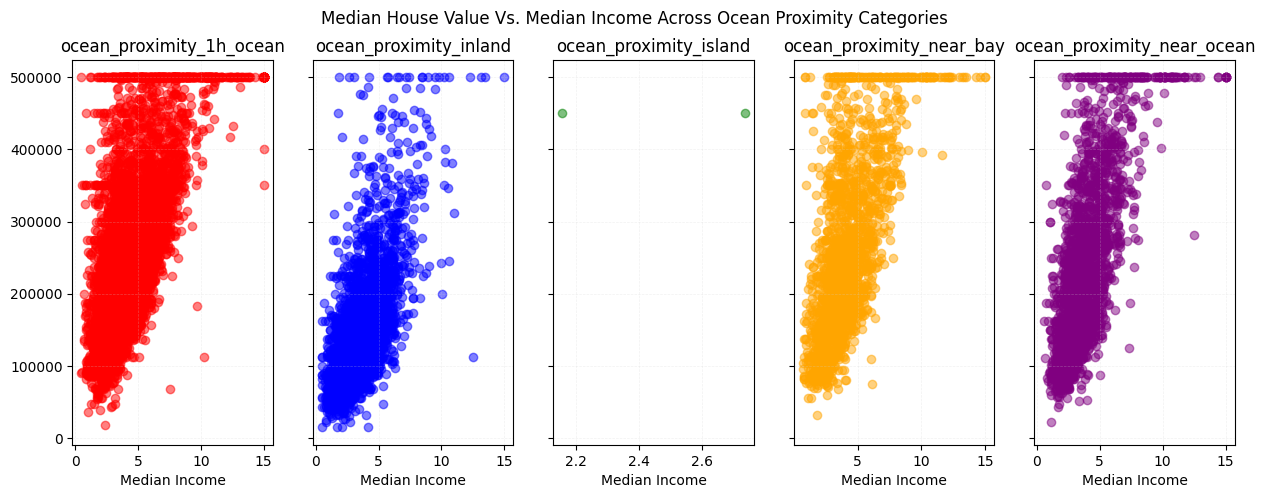

In [166]:
# scatter plot of median house value Vs. median income(color coded by ocean proximity)
colormap=['r', 'b', 'g', 'orange', 'purple']
ocean_cats = train_set.iloc[:,9:].columns

# create a subset for each category
fig,axes = plt.subplots(1, len(ocean_cats), figsize=(15,5), sharey=True)
for i,cat in enumerate(ocean_cats):
  ax = axes[i]
  flags = train_set[cat].astype(np.bool_)
  ax.scatter(train_set.median_income[flags],
             train_set.median_house_value[flags],
             color=colormap[i],
             alpha=0.5)
  ax.set_xlabel('Median Income')
  ax.set_title(cat)

# set common y-axix label and title
fig.suptitle('Median House Value Vs. Median Income Across Ocean Proximity Categories')

* The first observation is that median house value and median income are strongly correlated (≈ 0.7) across most categories, except for the “ISLAND” category, where the small sample size prevents any clear pattern from emerging.
* The “NEAR BAY” and “NEAR OCEAN” categories exhibit very similar trends, showing a consistent positive relationship between income and house value.
* Consistent with previous violin plot observations, the “INLAND” category shows significantly lower median house values compared to other regions. In this category, data points are sparse above $300,000, indicating that high-priced houses are rare inland.
* Across all plots, there appears to be a horizontal concentration around 500,000, suggesting a possible capping effect in the dataset. This anomaly may need to be addressed or filtered out during preprocessing.

Text(0.5, 0.98, 'Median House Value Vs. Total Rooms Across Ocean Proximity Categories')

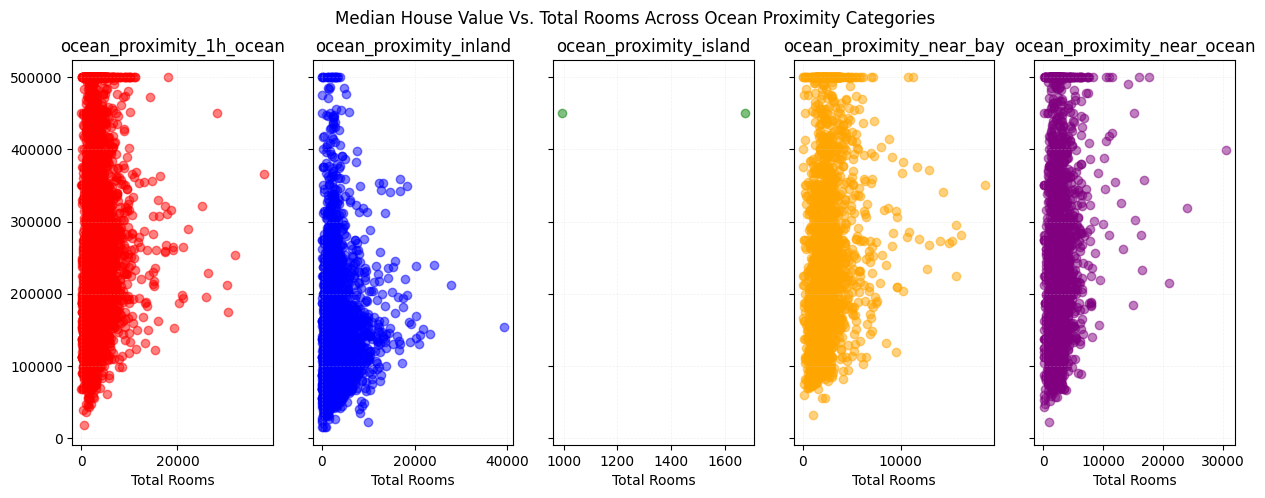

In [167]:
# scatter plot of median house value Vs. total rooms(color coded by ocean proximity)
colormap=['r', 'b', 'g', 'orange', 'purple']
ocean_cats = train_set.iloc[:,9:].columns

# create a subset for each category
fig,axes = plt.subplots(1, len(ocean_cats), figsize=(15,5), sharey=True)
for i,cat in enumerate(ocean_cats):
  ax = axes[i]
  flags = train_set[cat].astype(np.bool_)
  ax.scatter(train_set.total_rooms[flags],
             train_set.median_house_value[flags],
             color=colormap[i],
             alpha=0.5)
  ax.set_xlabel('Total Rooms')
  ax.set_title(cat)

# set common y-axix label and title
fig.suptitle('Median House Value Vs. Total Rooms Across Ocean Proximity Categories')

* Earlier, we observed that total rooms is not a particularly effective predictor of median house value. However, since overall trends can sometimes mask category-specific patterns, we examined this relationship across different ocean proximity categories.
* The results show no distinct or meaningful pattern within any category, and the behavior of each group closely mirrors the overall dataset, confirming that total rooms has limited predictive power for house prices in this dataset.

Text(0.5, 0.98, 'Median House Value Vs. Median Age Across Ocean Proximity Categories')

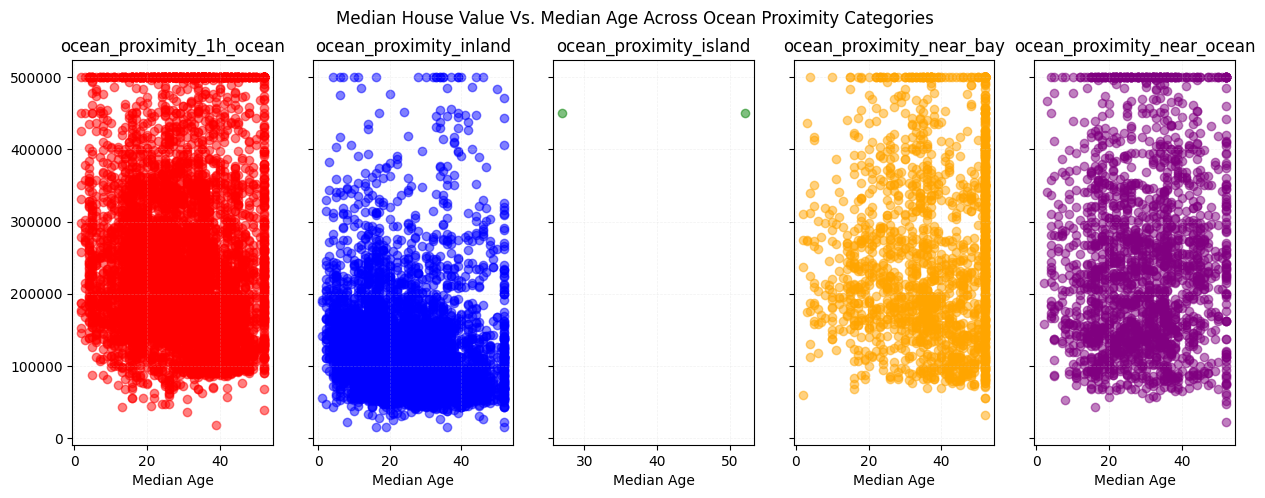

In [168]:
# scatter plot of median house value Vs. housing median age(color coded by ocean proximity)
colormap=['r', 'b', 'g', 'orange', 'purple']
ocean_cats = train_set.iloc[:,9:].columns

# create a subset for each category
fig,axes = plt.subplots(1, len(ocean_cats), figsize=(15,5), sharey=True)
for i,cat in enumerate(ocean_cats):
  ax = axes[i]
  flags = train_set[cat].astype(np.bool_)
  ax.scatter(train_set.housing_median_age[flags],
             train_set.median_house_value[flags],
             color=colormap[i],
             alpha=0.5)
  ax.set_xlabel('Median Age')
  ax.set_title(cat)

# set common y-axix label and title
fig.suptitle('Median House Value Vs. Median Age Across Ocean Proximity Categories')

* Housing median age is evenly distributed across all categories, with no strong relationship to house value.
* The INLAND category again has sparse data above $300,000.
* There appears to be a vertical cap around age 50, forming a clear vertical line in all categories, which may reflect a maximum recorded age for properties.

# 🔶Outliers

## ⮞Univariate Analysis

### ▸Numerical Features

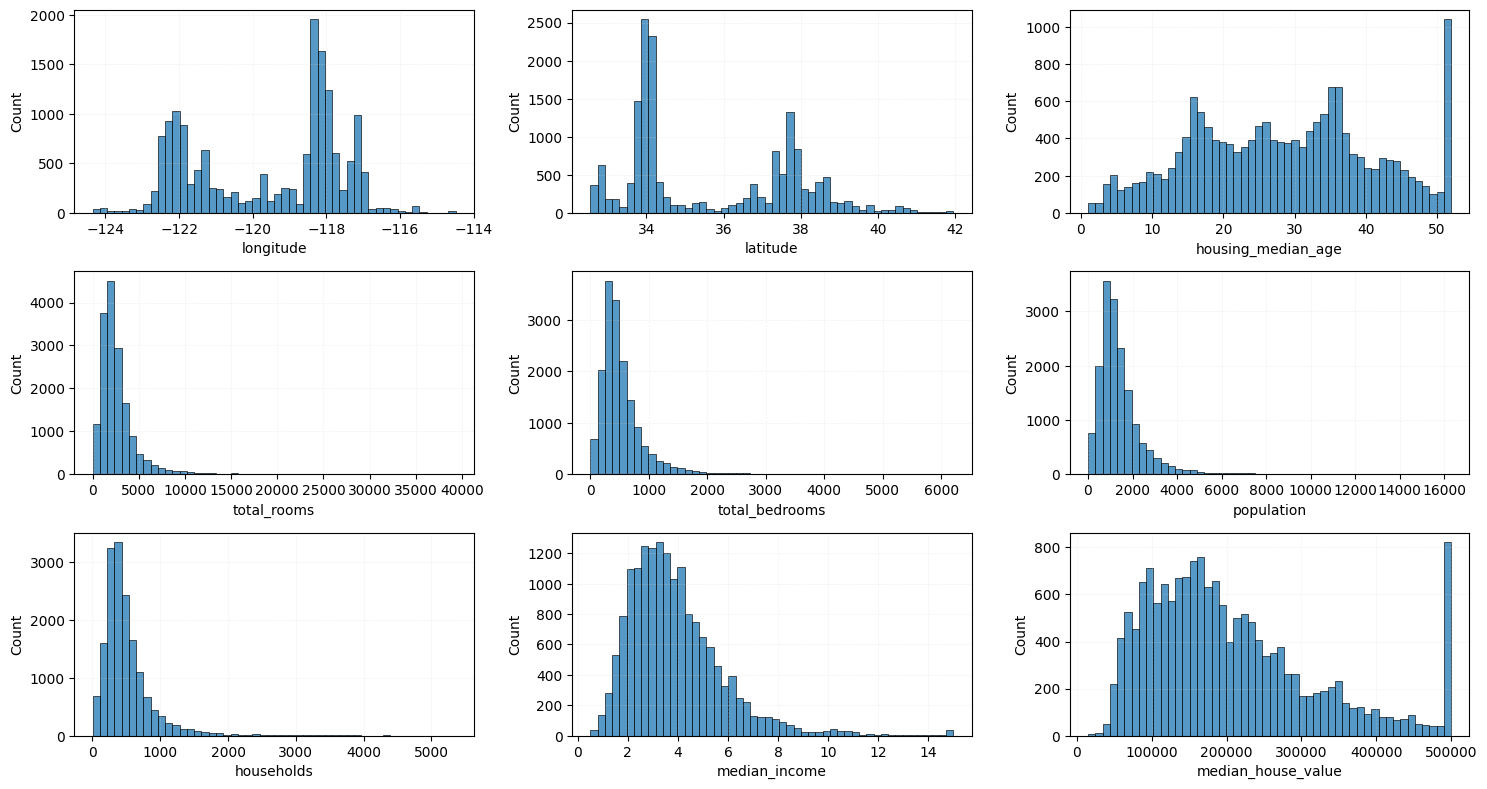

In [169]:
# Data Distribution:
numeric_cols = train_set.columns[:-5]
fig , ax = plt.subplots(3,3, figsize=(15,8))
flatten_ax = ax.flatten()

for i, col in enumerate(numeric_cols):
  ax = flatten_ax[i]
  sns.histplot(train_set[col], bins=50, ax=ax)
plt.tight_layout()
plt.show()

🔍 Outlier Analysis and Handling

Many features in the dataset exhibit right-skewed distributions, indicating the presence of outliers in the upper range.
Applying feature transformations can help normalize these distributions and reduce the influence of outliers on the model.

For right-skewed features, common transformation techniques include:
* Logarithmic Transformation
* Box–Cox Transformation
* Yeo–Johnson Transformation

In this step, we experiment with log, Box–Cox, and Yeo-Johnson transformations to determine which method produces a more normalized and stable distribution for our data.

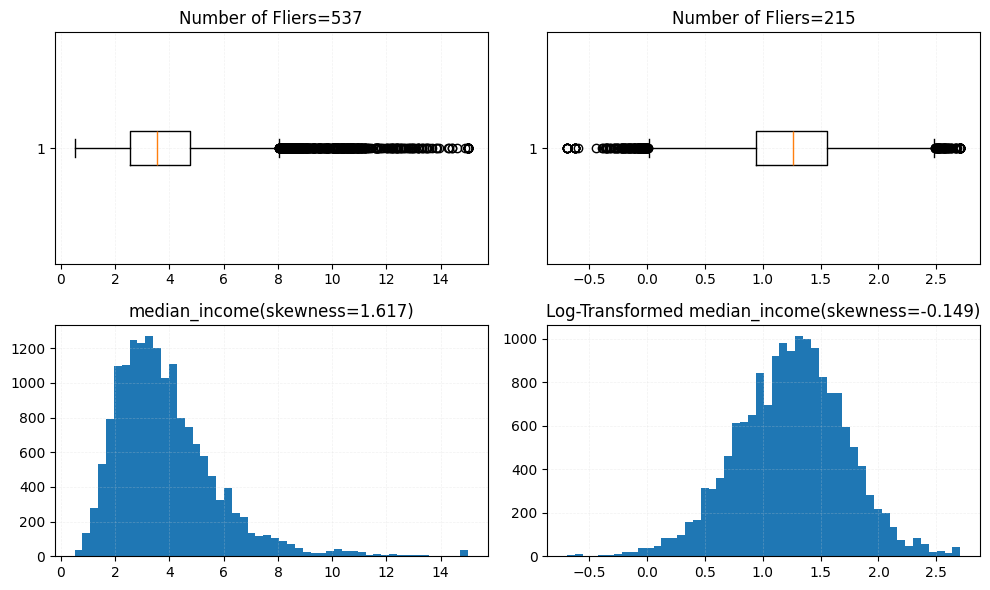

In [170]:
# Analyzing the distribution of median income and its log-transformed distribution:
fig, ax = plt.subplots(2,2, figsize=(10,6))

# box plot of the original median_income
fliers = ax[0][0].boxplot(train_set.median_income, vert=False, whis=1.5)['fliers'][0].get_ydata() # vert: vertical  # whis:determining the upper and lowe cap(Q1-1.5IQR)
ax[0][0].set_title(f'Number of Fliers={len(fliers)}')                                             # ['fliers'][0].get_ydata(): counts the number of outliers

# Histogram of original median_income
skewness_orig = skew(train_set.median_income)
ax[1][0].hist(train_set.median_income, 50)
ax[1][0].set_title(f'median_income(skewness={skewness_orig:.3f})')

# box plot of log-transformed median_income
log_median_income = np.log(train_set.median_income)
log_fliers = ax[0][1].boxplot(log_median_income, vert=False, whis=1.5)['fliers'][0].get_ydata()
ax[0][1].set_title(f'Number of Fliers={len(log_fliers)}')

# Histogram of log-transformed median_income
skewness_log = skew(log_median_income)
ax[1][1].hist(log_median_income, 50)
ax[1][1].set_title(f'Log-Transformed median_income(skewness={skewness_log:.3f})')

plt.tight_layout()
plt.show()

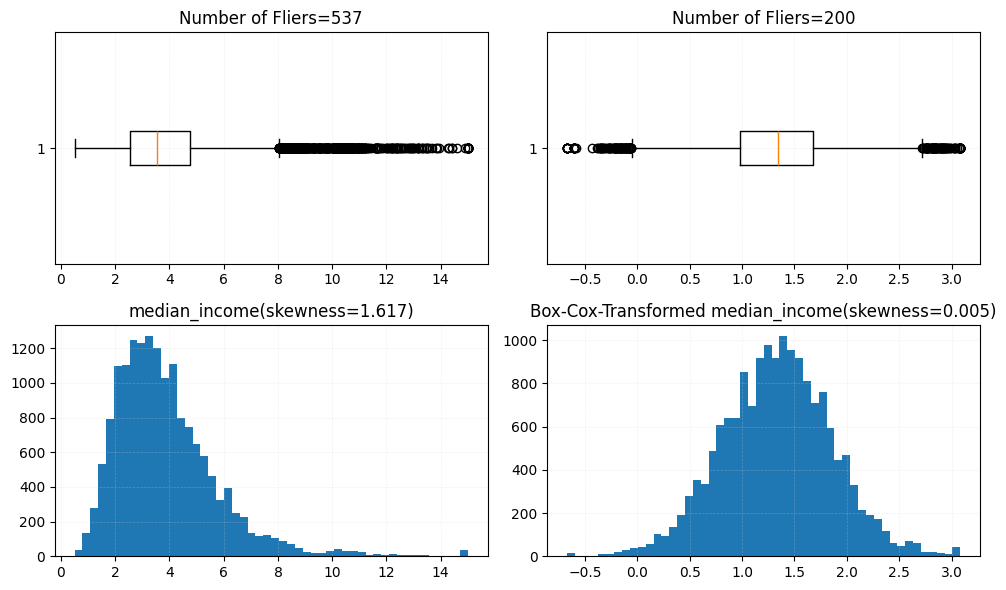

In [171]:
# Analyzing the distribution of median income and its boxcox-transformed distribution:
fig, ax = plt.subplots(2,2, figsize=(10,6))

# box plot of the original median_income
fliers = ax[0][0].boxplot(train_set.median_income, vert=False, whis=1.5)['fliers'][0].get_ydata() # vert: vertical  # whis:determining the upper and lowe cap(Q1-1.5IQR)
ax[0][0].set_title(f'Number of Fliers={len(fliers)}')                                             # ['fliers'][0].get_ydata(): counts the number of outliers

# Histogram of original median_income
skewness_orig = skew(train_set.median_income)
ax[1][0].hist(train_set.median_income, 50)
ax[1][0].set_title(f'median_income(skewness={skewness_orig:.3f})')

# box plot of box-cox-transformed median_income
transformed_median_income, lambda_ = boxcox(train_set.median_income)
boxcox_fliers = ax[0][1].boxplot(transformed_median_income, vert=False, whis=1.5)['fliers'][0].get_ydata()
ax[0][1].set_title(f'Number of Fliers={len(boxcox_fliers)}')

# Histogram of box-cox-transformed median_income
skewness_boxcox = skew(transformed_median_income)
ax[1][1].hist(transformed_median_income, 50)
ax[1][1].set_title(f'Box-Cox-Transformed median_income(skewness={skewness_boxcox:.3f})')

plt.tight_layout()
plt.show()

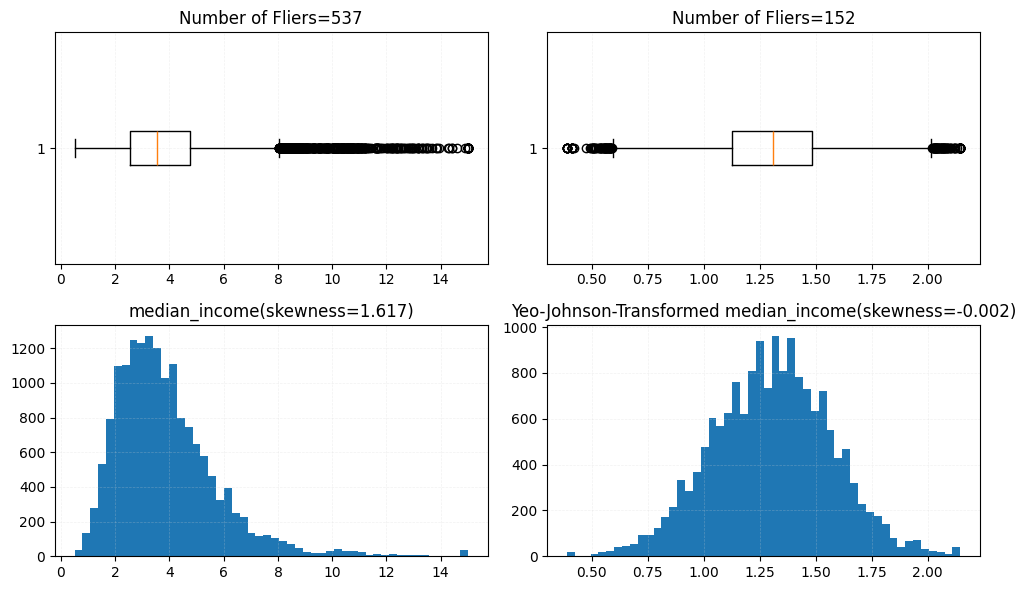

In [172]:
# Analyzing the distribution of median income and its yeo-johnson-transformed distribution:
fig, ax = plt.subplots(2,2, figsize=(10,6))

# box plot of the original median_income
fliers = ax[0][0].boxplot(train_set.median_income, vert=False, whis=1.5)['fliers'][0].get_ydata()
ax[0][0].set_title(f'Number of Fliers={len(fliers)}')

# Histogram of original median_income
skewness_orig = skew(train_set.median_income)
ax[1][0].hist(train_set.median_income, 50)
ax[1][0].set_title(f'median_income(skewness={skewness_orig:.3f})')

# box plot of yeo-johnson-transformed median_income
yj_transformed_median_income, lambda_ = yeojohnson(train_set.median_income)
yj_fliers = ax[0][1].boxplot(yj_transformed_median_income, vert=False, whis=1.5)['fliers'][0].get_ydata()
ax[0][1].set_title(f'Number of Fliers={len(yj_fliers)}')

# Histogram of yeo-johnson-transformed median_income
skewness_yj = skew(yj_transformed_median_income)
ax[1][1].hist(yj_transformed_median_income, 50)
ax[1][1].set_title(f'Yeo-Johnson-Transformed median_income(skewness={skewness_yj:.3f})')

plt.tight_layout()
plt.show()

| Transformation | Number of Outliers | Skewness |
| -------------- | ------------------ | -------- |
| Original       | 537                | 1.62     |
| Logarithmic    | 215                | -0.15    |
| Box–Cox        | 200                | 0.005    |
| Yeo–Johnson    | 152                | -0.002   |

As the Yeo-Johnson transformer shows better results and can reduce the number of outliers significantly, and handles the skewness better than the Logarithm transformer, we apply the Yeo-Johnson on the rest of the right-skewed features

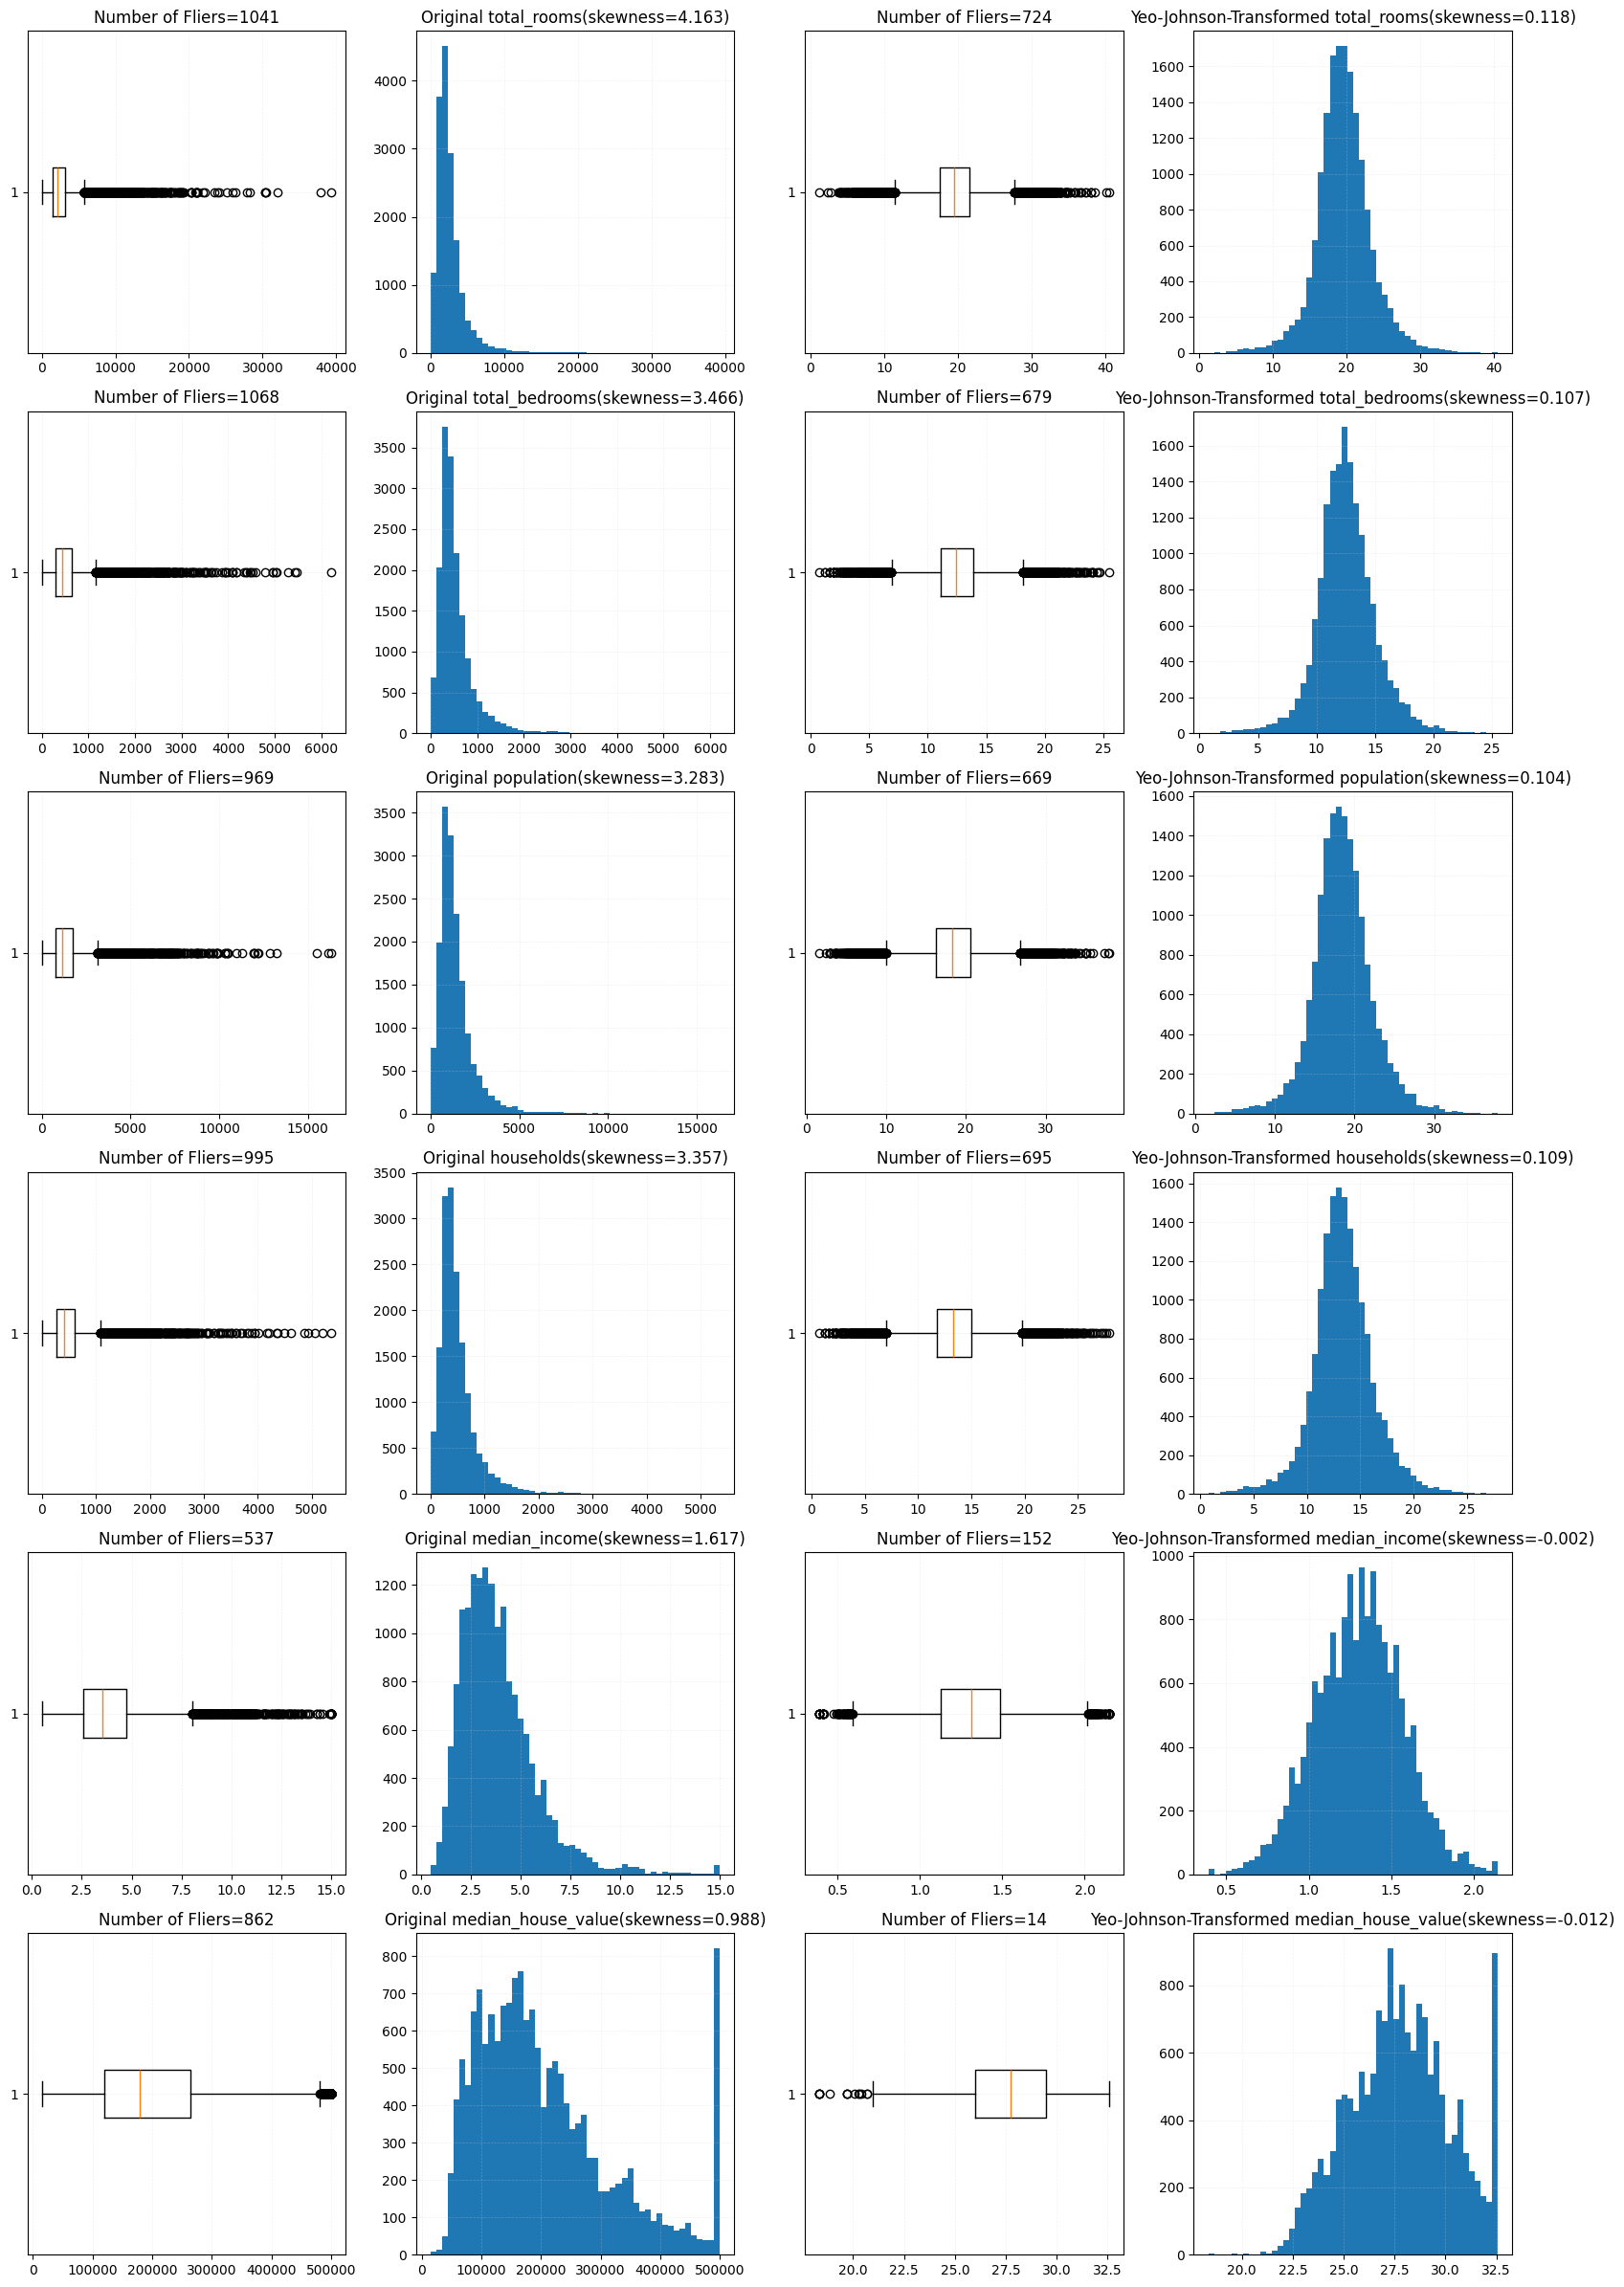

In [173]:
# Feature Transform using Yeo-Johnson Transformer:
cols_to_transform = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

fig, ax = plt.subplots(len(cols_to_transform), 4, figsize=(16,4*len(cols_to_transform)))
for i, col in enumerate(cols_to_transform):

  # box plot of the original feature
  fliers = ax[i,0].boxplot(train_set[col], vert=False, whis=1.5)['fliers'][0].get_ydata()
  ax[i,0].set_title(f'Number of Fliers={len(fliers)}')

  # Histogram of original feature
  skewness_orig = skew(train_set[col])
  ax[i,1].hist(train_set[col], 50)
  ax[i,1].set_title(f'Original {col}(skewness={skewness_orig:.3f})')

  # box plot of yeo-johnson-transformed feature
  transformed_feature, lambda_ = yeojohnson(train_set[col])
  yj_fliers = ax[i,2].boxplot(transformed_feature, vert=False, whis=1.5)['fliers'][0].get_ydata()
  ax[i,2].set_title(f'Number of Fliers={len(yj_fliers)}')

  # Histogram of yeo-johnson-transformed feature
  skewness_yj = skew(transformed_feature)
  ax[i,3].hist(transformed_feature, 50)
  ax[i,3].set_title(f'Yeo-Johnson-Transformed {col}(skewness={skewness_yj:.3f})')

plt.tight_layout()
plt.show()

In [174]:
# Make a copy of the dataset to apply feature transformation
preprocessed_train_set = train_set.copy()

In [175]:
# Apply feature transformation
cols_to_transform = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
lambda_list = []
for col in cols_to_transform:
  preprocessed_train_set[col], lm = yeojohnson(train_set[col])
  lambda_list.append(lm)      # This will be used for test_set feature transformation

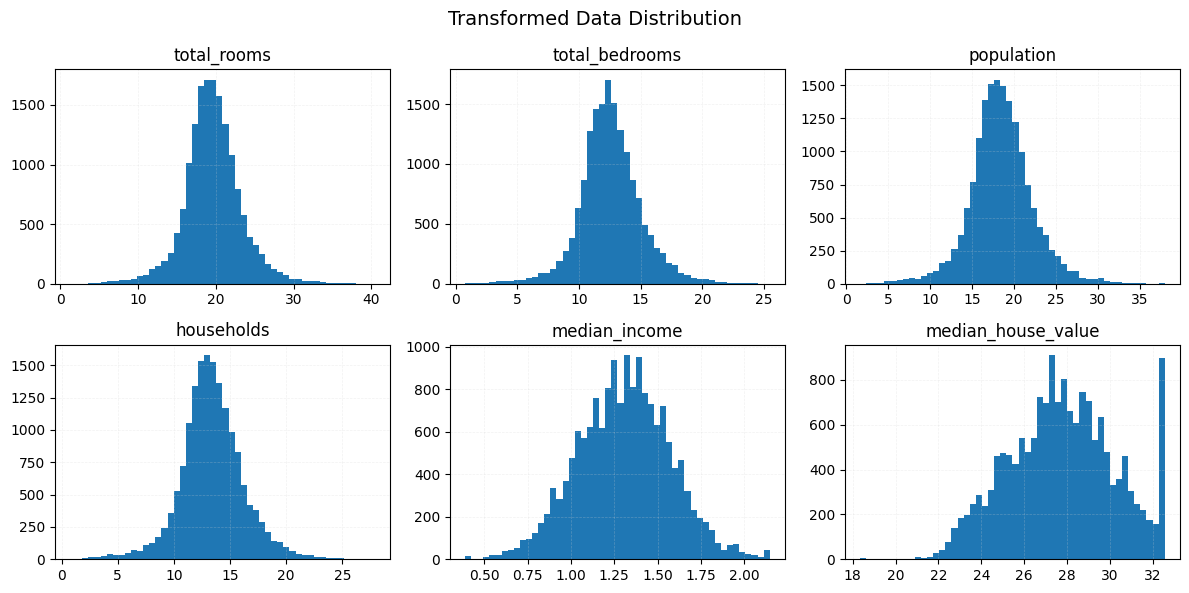

In [176]:
fig,ax = plt.subplots(2,3, figsize=(12,6))
flatten_ax = ax.flatten()
plt.suptitle('Transformed Data Distribution', fontsize=14)

for i,col in enumerate(cols_to_transform):
  ax = flatten_ax[i]
  ax.hist(preprocessed_train_set[col],50)
  ax.set_title(col)

plt.tight_layout()
plt.show()

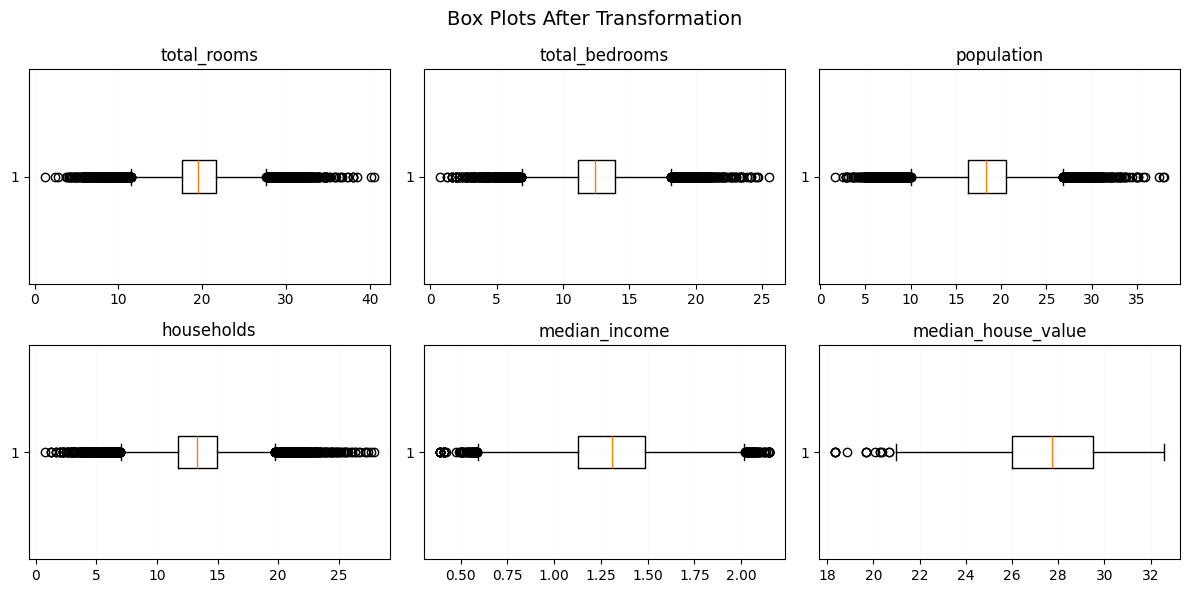

In [177]:
fig,ax = plt.subplots(2,3, figsize=(12,6))
flatten_ax = ax.flatten()
plt.suptitle('Box Plots After Transformation', fontsize=14)

for i,col in enumerate(cols_to_transform):
  ax = flatten_ax[i]
  ax.boxplot(preprocessed_train_set[col], vert=False)
  ax.set_title(col)

plt.tight_layout()
plt.show()

We use a modified IQR approach with wider caps (3.3 * IQR) to flag extreme outliers while preserving the majority of data.

This method ensures that extreme data points are mitigated while retaining most of the original dataset.

In [178]:
desc = preprocessed_train_set[cols_to_transform].describe()
Q1 = desc.loc['25%']
Q3 = desc.loc['75%']
IQR = Q3 - Q1
#lower_cap = Q1 - 1.5 * IQR   # we increase the range between two caps to 3.3IQR so that a smaller number of samples will be considered as outliers.
#upper_cap = Q3 + 1.5 * IQR
lower_cap = Q1 - 3.3 * IQR
upper_cap = Q3 + 3.3 * IQR

flags = (preprocessed_train_set[cols_to_transform] < lower_cap) | (preprocessed_train_set[cols_to_transform] > upper_cap)
flags.sum()

total_rooms           25
total_bedrooms        23
population            12
households            19
median_income          0
median_house_value     0
dtype: int64

In [179]:
# Summing up the outliers in rows to detect the actual number of outlier sampels withot overlappng
print(f' Total number of outlier samples: {flags.sum(1).astype(np.bool_).sum()}')

 Total number of outlier samples: 36


In [180]:
lower_cap , upper_cap

(total_rooms            4.220854
 total_bedrooms         1.823933
 population             2.439494
 households             1.268712
 median_income         -0.053817
 median_house_value    14.476012
 dtype: float64,
 total_rooms           34.925819
 total_bedrooms        23.198859
 population            34.390763
 households            25.465083
 median_income          2.664360
 median_house_value    41.023600
 dtype: float64)

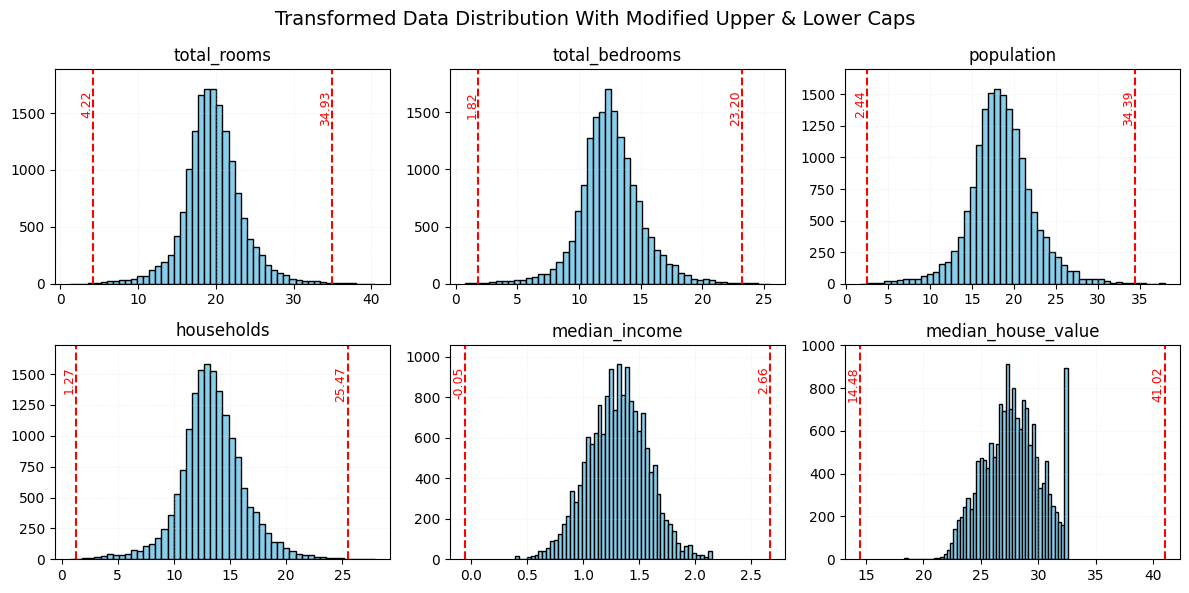

In [181]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
flatten_ax = ax.flatten()
plt.suptitle('Transformed Data Distribution With Modified Upper & Lower Caps', fontsize=14)

for i, col in enumerate(cols_to_transform):
    axis = flatten_ax[i]
    counts, bins, patches = axis.hist(preprocessed_train_set[col], bins=50, color='skyblue', edgecolor='black')

    # Dynamic y-limits for better visualization
    ymax = counts.max() * 1.1  # add a bit of headroom
    axis.set_ylim(0, ymax)

    # Add vlines for caps
    axis.vlines(lower_cap[col], ymin=0, ymax=ymax, color='red', ls='--')
    axis.vlines(upper_cap[col], ymin=0, ymax=ymax, color='red', ls='--')

    # Annotate vline values
    axis.text(lower_cap[col], ymax*0.9, f"{lower_cap[col]:.2f}", color='red', fontsize=9, rotation=90, va='top', ha='right')
    axis.text(upper_cap[col], ymax*0.9, f"{upper_cap[col]:.2f}", color='red', fontsize=9, rotation=90, va='top', ha='right')

    # Titles
    axis.set_title(col)

plt.tight_layout()
plt.show()

In [182]:
# dropping the outliers(outside the range of caps)

print(f'Number of samples before dropping the outliers:{preprocessed_train_set.shape[0]}')
print(f'Number of outliers to drop:{flags.sum(1).astype(np.bool_).sum()}')

# drop
preprocessed_train_set = preprocessed_train_set[~flags.sum(1).astype(np.bool_)]

print(f'Number of samples after dropping the outliers:{preprocessed_train_set.shape[0]}')

Number of samples before dropping the outliers:16512
Number of outliers to drop:36
Number of samples after dropping the outliers:16476


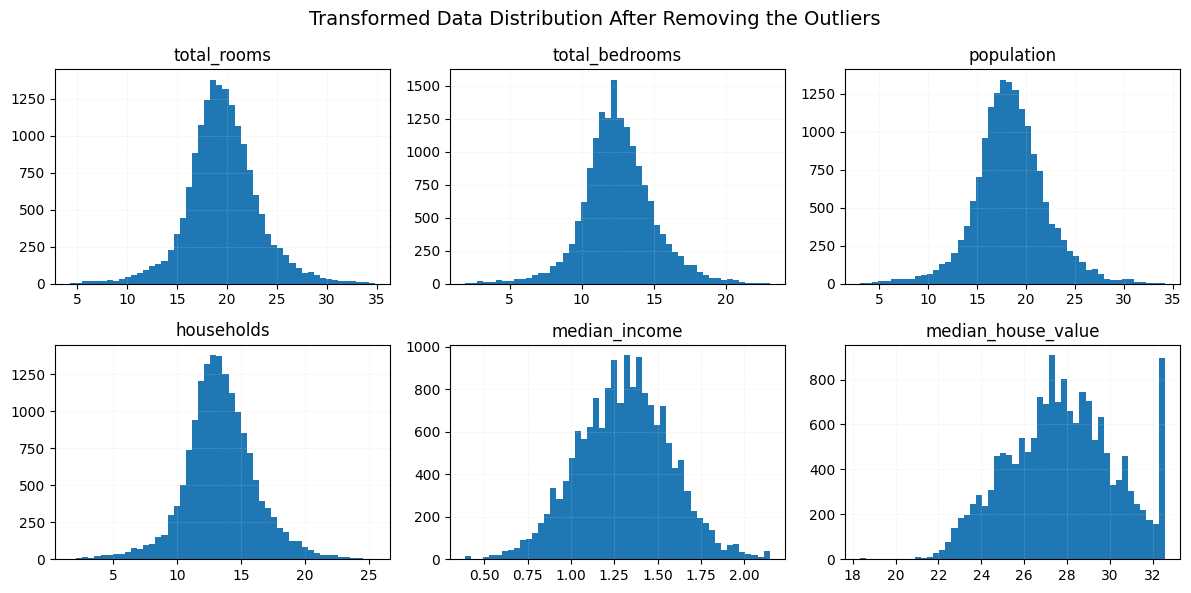

In [183]:
fig,ax = plt.subplots(2,3, figsize=(12,6))
flatten_ax = ax.flatten()
plt.suptitle('Transformed Data Distribution After Removing the Outliers', fontsize=14)

for i,col in enumerate(cols_to_transform):
  ax = flatten_ax[i]
  ax.hist(preprocessed_train_set[col],50)
  ax.set_title(col)

plt.tight_layout()
plt.show()

The median_house_value feature exhibits a capping effect at $500,000, affecting approximately 800 samples in the dataset. This artificial ceiling distorts the distribution and can negatively impact model performance.

To address this, we remove the capped values and retain only the uncapped portion of the data.

Number of outliers in median_house_value: 807


Text(0.5, 1.0, 'Median House Value Without the Outlier Bar at $500000(32.5 after transformation)')

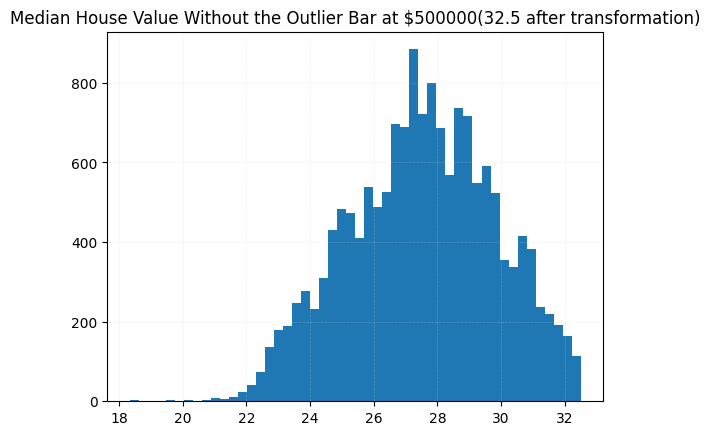

In [184]:
# Handling the outliers in median_house_value(~800 samples at $500,000)
flags = preprocessed_train_set.median_house_value < 32.5
print(f'Number of outliers in median_house_value: {(~flags).sum()}')
plt.hist(preprocessed_train_set.median_house_value[flags], 50);
plt.title('Median House Value Without the Outlier Bar at $500000(32.5 after transformation)')

Number of outliers:807


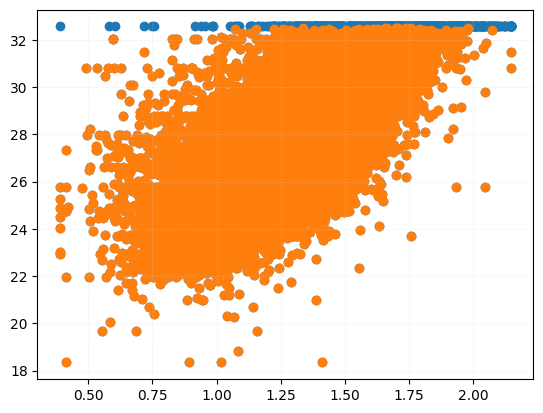

In [185]:
plt.scatter(preprocessed_train_set.median_income, preprocessed_train_set.median_house_value)
plt.scatter(preprocessed_train_set.median_income[flags], preprocessed_train_set.median_house_value[flags])

print(f'Number of outliers:{(~flags).sum()}')

In [186]:
# dropping the outliers(capped at $500,000)

print(f'Number of samples before dropping the outliers:{preprocessed_train_set.shape[0]}')
print(f'Number of outliers to drop:{(~flags).sum()}')

# drop
preprocessed_train_set = preprocessed_train_set[flags]

print(f'Number of samples after dropping the outliers:{preprocessed_train_set.shape[0]}')

Number of samples before dropping the outliers:16476
Number of outliers to drop:807
Number of samples after dropping the outliers:15669


Text(0.5, 1.0, 'Median House Value After Dropping the Outliers')

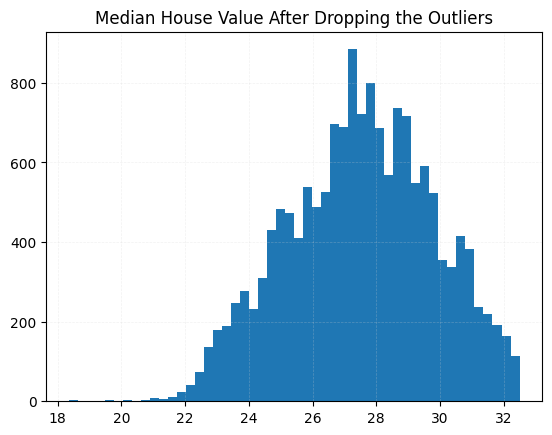

In [187]:
plt.hist(preprocessed_train_set.median_house_value, 50);
plt.title('Median House Value After Dropping the Outliers')

After applying the Yeo-Johnson transformation, the median_house_value feature still exhibits a slight left skew. To correct this and further normalize the distribution, a power transformation is applied:

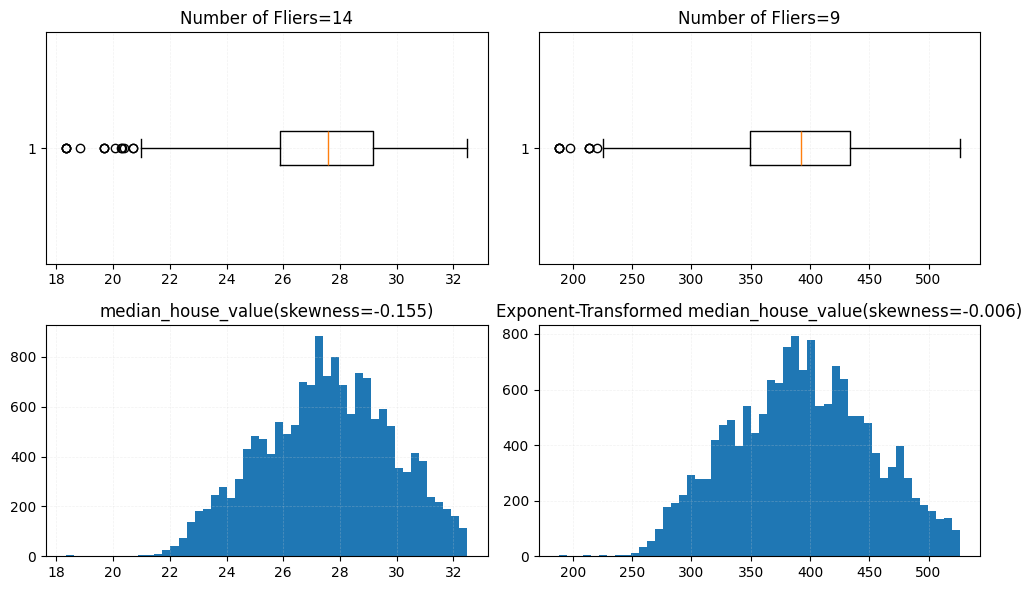

In [188]:
# Analyzing the distribution of median house value and its exponent-transformed distribution:
fig, ax = plt.subplots(2,2, figsize=(10,6))

# box plot of the original median_income
fliers = ax[0][0].boxplot(preprocessed_train_set.median_house_value, vert=False, whis=1.5)['fliers'][0].get_ydata()
ax[0][0].set_title(f'Number of Fliers={len(fliers)}')

# Histogram of original median_income
skewness_orig = skew(preprocessed_train_set.median_house_value)
ax[1][0].hist(preprocessed_train_set.median_house_value, 50)
ax[1][0].set_title(f'median_house_value(skewness={skewness_orig:.3f})')

# box plot of exponent-transformed median_income
p_median_house_value = (preprocessed_train_set.median_house_value)**1.8
p_fliers = ax[0][1].boxplot(p_median_house_value, vert=False, whis=1.5)['fliers'][0].get_ydata()
ax[0][1].set_title(f'Number of Fliers={len(p_fliers)}')

# Histogram of exponent-transformed median_income
skewness_p = skew(p_median_house_value)
ax[1][1].hist(p_median_house_value, 50)
ax[1][1].set_title(f'Exponent-Transformed median_house_value(skewness={skewness_p:.3f})')

plt.tight_layout()
plt.show()

In [189]:
# Apply exponent feature transform on median house value to fix the left skew

preprocessed_train_set['median_house_value'] = (preprocessed_train_set.median_house_value)**1.8

Text(0.5, 1.0, 'median_house_value Distribution After Applying Exponent Transformation')

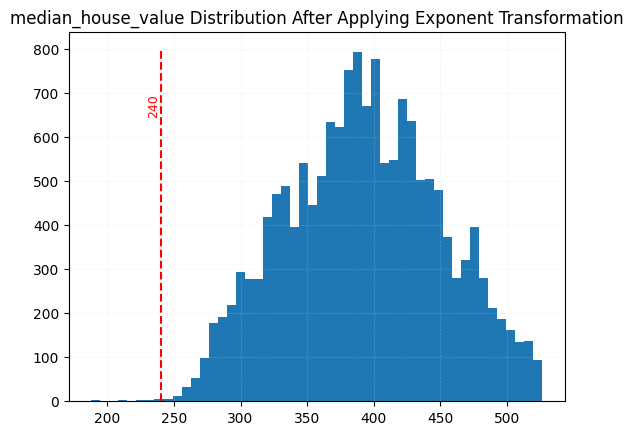

In [190]:
plt.hist(preprocessed_train_set['median_house_value'],50)
plt.vlines(240, 0, 800, color='r', ls='--')
plt.text(240, 700, "240", color='red', fontsize=9, rotation=90, va='top', ha='right')
plt.title('median_house_value Distribution After Applying Exponent Transformation')

In [191]:
# dropping the outliers(Lower than 240)
flags = preprocessed_train_set['median_house_value'] < 240
print(f'Number of samples before dropping the outliers:{preprocessed_train_set.shape[0]}')
print(f'Number of outliers to drop:{flags.sum()}')

# drop
preprocessed_train_set = preprocessed_train_set[~flags]

print(f'Number of samples after dropping the outliers:{preprocessed_train_set.shape[0]}')

Number of samples before dropping the outliers:15669
Number of outliers to drop:18
Number of samples after dropping the outliers:15651


Text(0.5, 1.0, 'median_house_value Distribution After Removing the Outliers')

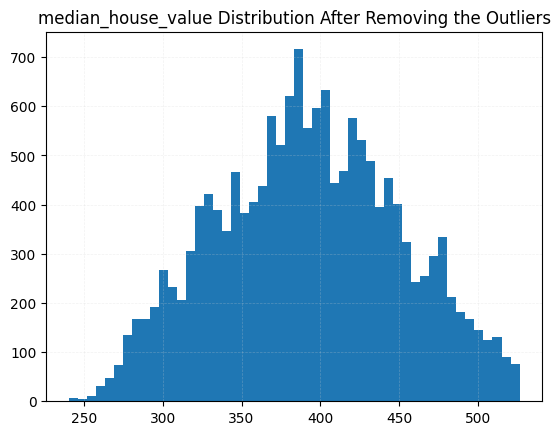

In [192]:
plt.hist(preprocessed_train_set['median_house_value'],50)
plt.title('median_house_value Distribution After Removing the Outliers')

### ▸Categorical Features

In [193]:
preprocessed_train_set.iloc[:, 9:].sum()

ocean_proximity_1h_ocean      6814.0
ocean_proximity_inland        5252.0
ocean_proximity_island           2.0
ocean_proximity_near_bay      1679.0
ocean_proximity_near_ocean    1904.0
dtype: float64

The ocean_proximity_island category contains only 2 samples, making it statistically insignificant.
Including it in the modeling process may introduce noise and bias, as it does not represent a meaningful pattern in housing data.

Considering the sample size and other mentioned reasons in the EDA section, we remove this category:

In [194]:
# Dropping the ocean_proximity_island due to the mentioned reasons
preprocessed_train_set.drop(columns='ocean_proximity_island', inplace=True)
preprocessed_train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0    21.885560       16.237258   
14973    -118.38     34.14                40.0    19.059757       11.705350   
3785     -121.98     38.36                33.0    16.215315       10.087305   
14689    -117.11     33.75                17.0    23.219759       15.067641   
20507    -118.15     33.77                36.0    23.490025       16.608470   

       population  households  median_income  median_house_value  \
13096   19.989298   17.559147       1.015860          515.734944   
14973   15.516368   12.730667       1.630253          523.506281   
3785    14.737976   10.622497       1.097377          336.524088   
14689   20.911629   16.158466       1.056877          331.008794   
20507   21.125243   18.212246       1.309943          482.986761   

       ocean_proximity_1h_ocean  ocean_proximity_inland  \
13096                       0.0                     0.0   
14973                       1.0                     0.0   
3785                        0.0                     1.0   
14689                       0.0                     1.0   
20507                       0.0                     0.0   

       ocean_proximity_near_bay  ocean_proximity_near_ocean  
13096                       1.0                         0.0  
14973                       0.0                         0.0  
3785                        0.0                         0.0  
14689                       0.0                         0.0  
20507                       0.0                         1.0

## ⮞Bivariate Analysis

In the bivariate analysis, we examine relationships between the target variable (median_house_value) and numerical features to identify potential outliers that may distort the predictive modeling process. Outliers were detected using scatter plots and logical thresholds/linear boundaries for each feature.

In [195]:
# Make a copy of the dataset to later examine the model's performance with and without the outliers
clean_train_set = preprocessed_train_set.copy()

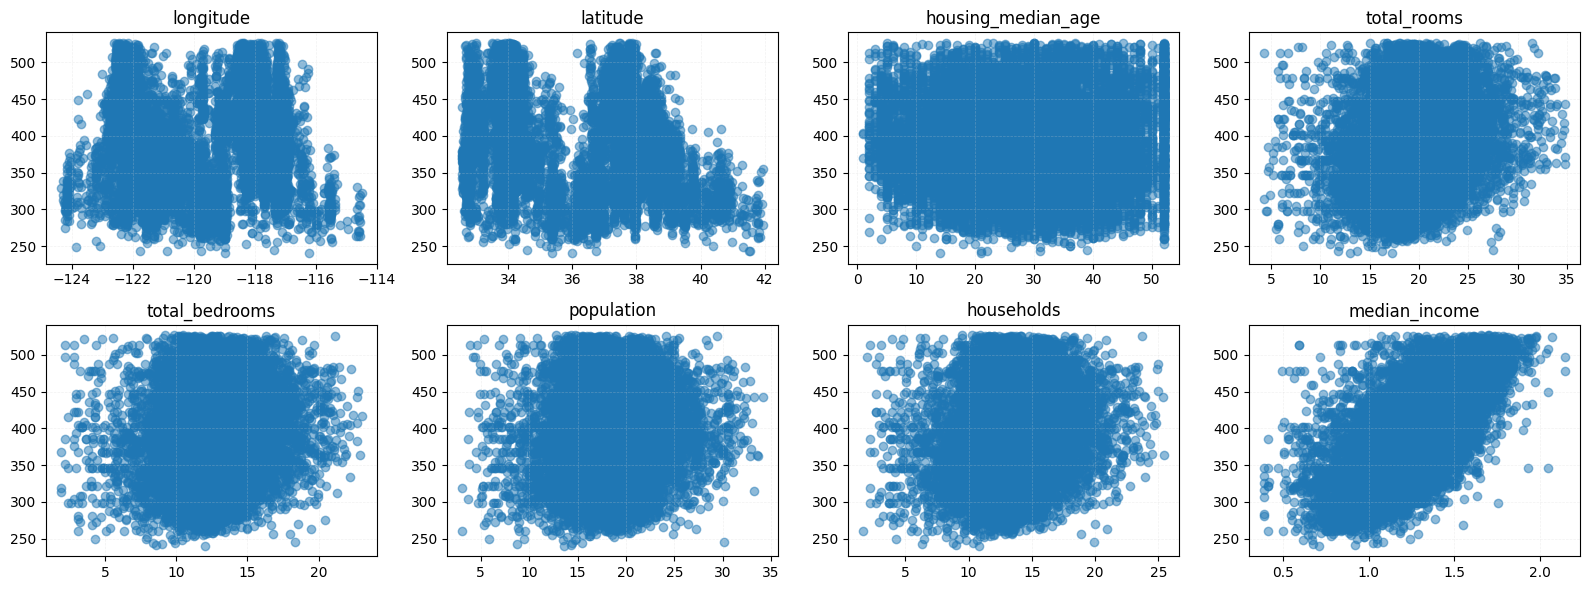

In [196]:
numeric_cols = clean_train_set.columns[:-4]
fig, ax = plt.subplots(2,4, figsize=(16,6))
flatten_ax = ax.flatten()
for i, col in enumerate(clean_train_set[numeric_cols]):
  if col != 'median_house_value':
    ax = flatten_ax[i]
    ax.scatter(clean_train_set[col], clean_train_set['median_house_value'], alpha=0.5)
    ax.set_title(col)
plt.tight_layout()

Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Longitude: 24')

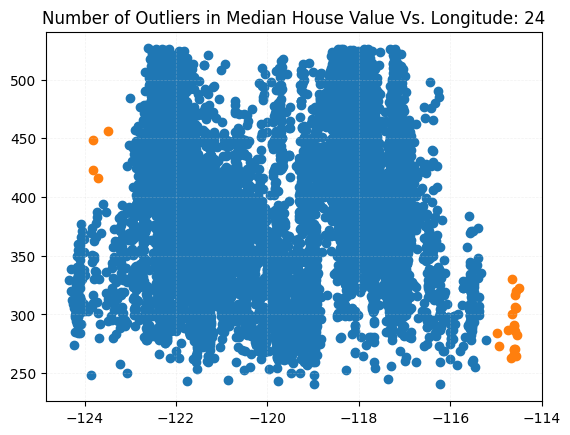

In [197]:
# Outliers in longitude
flag1 = (clean_train_set.longitude < -123.2) & (clean_train_set.median_house_value > 410)
flag2 = clean_train_set.longitude > -115
flags = flag1 | flag2
count = flags.sum()

plt.scatter(clean_train_set.longitude[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.longitude[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Longitude: {count}')

In [198]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:15651
Number of outliers to drop:24
Number of samples after dropping the outliers:15627


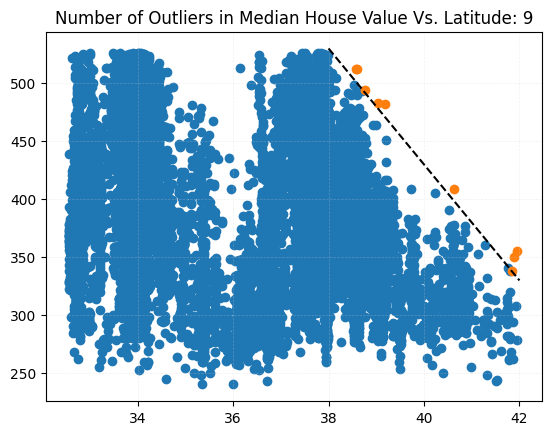

In [199]:
# Outliers in latitude
m = -50
b = 2430
flag1 = clean_train_set.median_house_value > (m * clean_train_set.latitude + b)
flags =  flag1
count = flags.sum()

plt.scatter(clean_train_set.latitude[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.latitude[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Latitude: {count}')

# Plot the line
lat_range = np.linspace(38,42, 20)
plt.plot(lat_range, m * lat_range + b, 'k--')

In [200]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:15627
Number of outliers to drop:9
Number of samples after dropping the outliers:15618


Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Housing_median_age: 869')

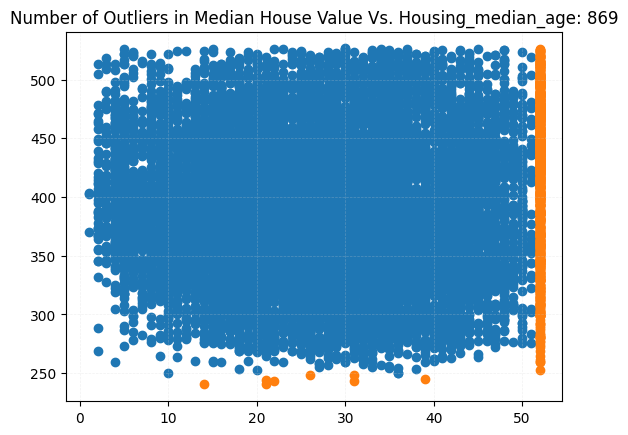

In [201]:
# Outliers in housing_median_age
flag1 = clean_train_set.median_house_value < 250
flag2 = clean_train_set.housing_median_age > 51
flags = flag1 | flag2
count = flags.sum()

plt.scatter(clean_train_set.housing_median_age[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.housing_median_age[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Housing_median_age: {count}')

In [202]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:15618
Number of outliers to drop:869
Number of samples after dropping the outliers:14749


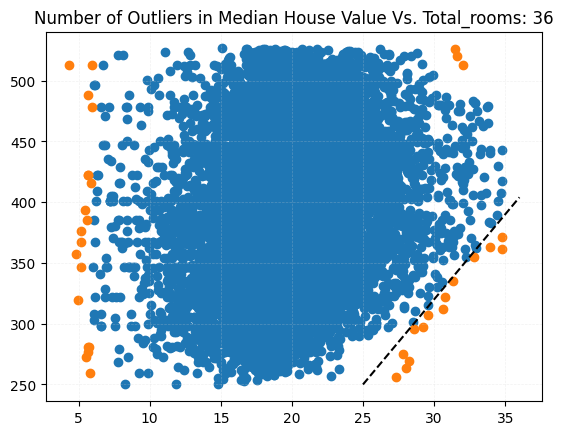

In [203]:
# Outliers in total_rooms
m = 14
b = -100
flag1 = clean_train_set.median_house_value < (m * clean_train_set.total_rooms + b)
flag2 = (clean_train_set.total_rooms > 31) & (clean_train_set.median_house_value > 510)
flag3 = clean_train_set.total_rooms < 6
flags =  flag1 | flag2 | flag3
count = flags.sum()

plt.scatter(clean_train_set.total_rooms[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.total_rooms[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Total_rooms: {count}')

# Plot the line
l_range = np.linspace(25,36, 20)
plt.plot(l_range, m * l_range + b, 'k--')

In [204]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14749
Number of outliers to drop:36
Number of samples after dropping the outliers:14713


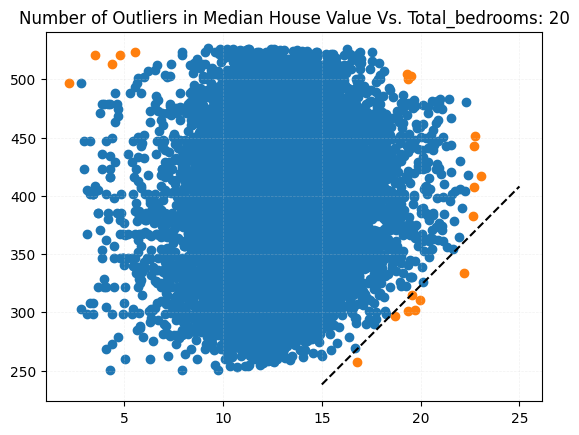

In [205]:
# Outliers in total_bedrooms
m = 17
b = -17
flag1 = clean_train_set.median_house_value < (m * clean_train_set.total_bedrooms + b)
flag2 = (clean_train_set.total_bedrooms > 18.5) & (clean_train_set.median_house_value > 500)
flag3 = (clean_train_set.total_bedrooms < 6) & (clean_train_set.median_house_value > 501)
flag4 = (clean_train_set.total_bedrooms > 22.5) | (clean_train_set.total_bedrooms < 2.5)
flags =  flag1 | flag2 | flag3 | flag4
count = flags.sum()

plt.scatter(clean_train_set.total_bedrooms[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.total_bedrooms[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Total_bedrooms: {count}')

# Plot the line
l_range = np.linspace(15,25, 20)
plt.plot(l_range, m * l_range + b, 'k--')

In [206]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14713
Number of outliers to drop:20
Number of samples after dropping the outliers:14693


Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Population: 5')

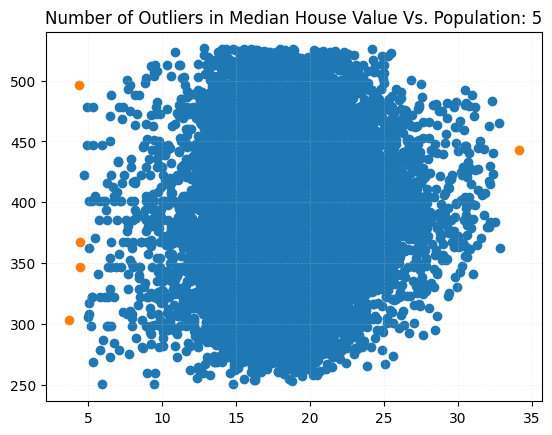

In [207]:
# Outliers in population
flag1 = clean_train_set.median_house_value < 250
flag2 = (clean_train_set.population < 4.5) | (clean_train_set.population > 33)
flags = flag1 | flag2
count = flags.sum()

plt.scatter(clean_train_set.population[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.population[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Population: {count}')

In [208]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14693
Number of outliers to drop:5
Number of samples after dropping the outliers:14688


Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Households: 24')

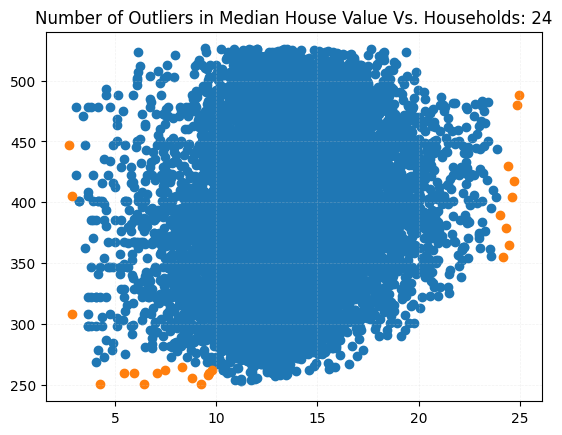

In [209]:
# Outliers in households
flag1 = (clean_train_set.households > 20) & (clean_train_set.median_house_value > 500)
flag2 = (clean_train_set.households < 3) | (clean_train_set.households > 24)
flag3 = (clean_train_set.households < 10) & (clean_train_set.median_house_value < 265)
flags = flag1 | flag2 | flag3
count = flags.sum()

plt.scatter(clean_train_set.households[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.households[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Households: {count}')

In [210]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14688
Number of outliers to drop:24
Number of samples after dropping the outliers:14664


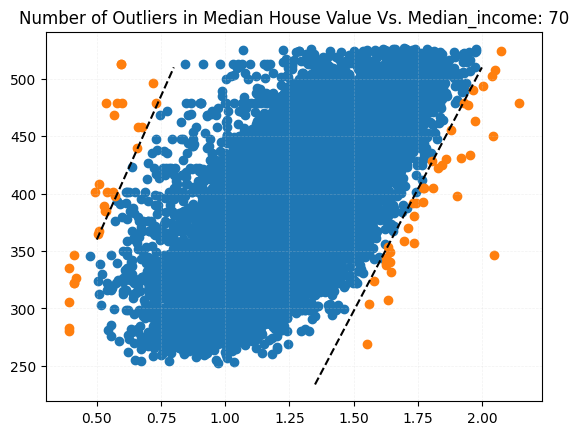

In [211]:
# Outliers in median_income
m1 = 425
b1 = -340
m2 = 500
b2 = 110
flag1 = clean_train_set.median_house_value < (m1 * clean_train_set.median_income + b1)
flag2 = clean_train_set.median_house_value > (m2 * clean_train_set.median_income + b2)
flag3 = (clean_train_set.median_income < 0.45)
flags = flag1 | flag2 | flag3
count = flags.sum()

plt.scatter(clean_train_set.median_income[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.median_income[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Median_income: {count}')
# Plot the lines
l1_range = np.linspace(1.35,2, 20)
plt.plot(l1_range, m1 * l1_range + b1, 'k--')
l2_range = np.linspace(0.5,0.8, 20)
plt.plot(l2_range, m2 * l2_range + b2, 'k--')

In [212]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14664
Number of outliers to drop:70
Number of samples after dropping the outliers:14594


Now that we have identified the outliers through bivariate analysis, we can evaluate their impact on the model. The approach is to first use the dataset that retains all outliers(preprocessed_train_set), build and train the model, and record its performance. Then, we can use the dataset in which the detected outliers are removed(clean_train_set), retrain the model, and compare the results.

By examining the performance difference between the two scenarios, we can make an informed decision about whether keeping or removing the outliers leads to a more robust and reliable model.

# 🔶Data/Feature Reduction

In [213]:
corr = preprocessed_train_set.corr()
corr[['median_house_value']].abs().sort_values(by='median_house_value')

median_house_value
longitude                             0.028536
housing_median_age                    0.046773
population                            0.051845
total_bedrooms                        0.109908
ocean_proximity_near_ocean            0.131981
households                            0.138668
ocean_proximity_near_bay              0.164057
latitude                              0.182600
total_rooms                           0.197033
ocean_proximity_1h_ocean              0.337791
ocean_proximity_inland                0.554134
median_income                         0.649528
median_house_value                    1.000000

**Interpretation on Feature Selection**

At this stage, we examine the strength of the relationship between each feature and the target variable to guide feature selection. Columns with very low correlation or weak relevance to the prediction task—such as housing median age or population—could potentially be removed depending on the project needs.

Also, for simplicity, PCA (Principal Component Analysis) or other dimensionality reduction techniques were not applied.

For now, we will keep all features to avoid prematurely discarding information that may still contribute to model performance. Later, once we build and evaluate our models, we can revisit feature selection and decide whether removing certain features improves model accuracy, simplifies the model, or speeds up computation.

# 🔶X & Y Split

In [214]:
# Separate the dataset into features (X) and the target variable (y)- Outliers retained
x_train = preprocessed_train_set.drop(columns=['median_house_value'])
y_train = preprocessed_train_set['median_house_value']

x_train.shape, y_train.shape

((15651, 12), (15651,))

In [215]:
# Separate the dataset into features (X) and the target variable (y)- Outliers removed
x_train_c = clean_train_set.drop(columns=['median_house_value'])
y_train_c = clean_train_set['median_house_value']

x_train_c.shape, y_train_c.shape

((14594, 12), (14594,))

# 🔶Test Set Preprocessing

In [216]:
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3905     -121.95     37.11                21.0       2387.0           357.0   
16821    -118.01     33.89                36.0       1589.0           265.0   
2900     -118.18     33.74                30.0       5915.0          1750.0   
7193     -122.48     37.74                52.0       2166.0           423.0   
13928    -122.39     37.78                 5.0       1405.0           515.0   

       population  households  median_income  median_house_value  \
3905        913.0       341.0         7.7360            397700.0   
16821       804.0       272.0         4.6354            202900.0   
2900       2136.0      1503.0         4.0968            310000.0   
7193       1072.0       370.0         4.1310            314300.0   
13928       725.0       392.0         3.6037            187500.0   

      ocean_proximity  
3905        <1H OCEAN  
16821       <1H OCEAN  
2900       NEAR OCEAN  
7193       NEAR OCEAN  
13928        NEAR BAY

## ⮞Missing Values

<Axes: >

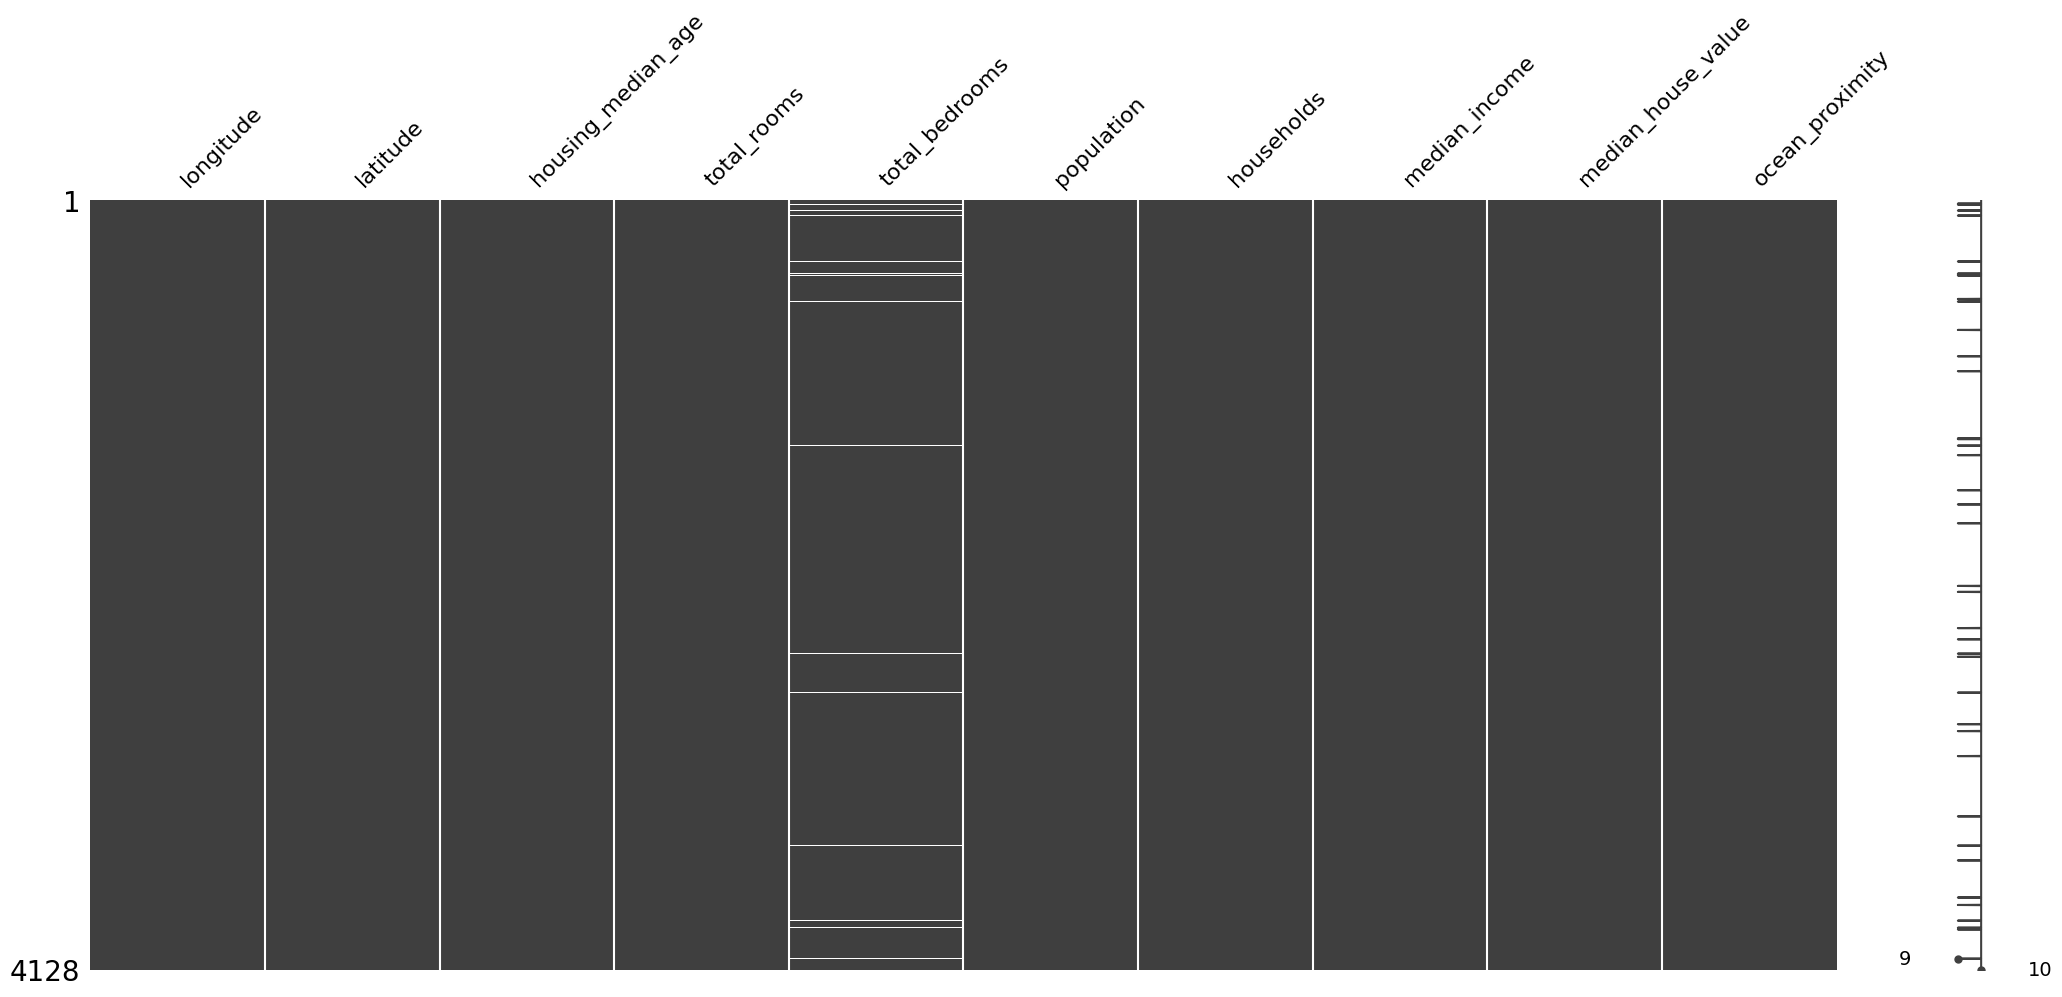

In [217]:
msno.matrix(test_set)

In [218]:
test_set.isna().sum()

longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms        39
population             0
households             0
median_income          0
median_house_value     0
ocean_proximity        0
dtype: int64

We impute missing values in the test set using the median computed **only from the training set**.
This avoids data leakage and simulates real-world deployment, where future data does not influence preprocessing.


In [219]:
# Replacing the missing values in the test_set using the median of train_set
test_set.fillna({'total_bedrooms' : train_median}, inplace=True)
test_set.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## ⮞Encoding Categorical Features

In [220]:
# apply the same encoding strategy as used in the training set
test_set = pd.get_dummies(test_set, columns=['ocean_proximity'], dtype=np.float64)
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3905     -121.95     37.11                21.0       2387.0           357.0   
16821    -118.01     33.89                36.0       1589.0           265.0   
2900     -118.18     33.74                30.0       5915.0          1750.0   
7193     -122.48     37.74                52.0       2166.0           423.0   
13928    -122.39     37.78                 5.0       1405.0           515.0   

       population  households  median_income  median_house_value  \
3905        913.0       341.0         7.7360            397700.0   
16821       804.0       272.0         4.6354            202900.0   
2900       2136.0      1503.0         4.0968            310000.0   
7193       1072.0       370.0         4.1310            314300.0   
13928       725.0       392.0         3.6037            187500.0   

       ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
3905                         1.0                     0.0   
16821                        1.0                     0.0   
2900                         0.0                     0.0   
7193                         0.0                     0.0   
13928                        0.0                     0.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
3905                      0.0                       0.0   
16821                     0.0                       0.0   
2900                      0.0                       0.0   
7193                      0.0                       0.0   
13928                     0.0                       1.0   

       ocean_proximity_NEAR OCEAN  
3905                          0.0  
16821                         0.0  
2900                          1.0  
7193                          1.0  
13928                         0.0

In [221]:
# Lower case, No space
test_set.rename(columns={'ocean_proximity_<1H OCEAN' : 'ocean_proximity_1h_ocean',
                          'ocean_proximity_INLAND' :'ocean_proximity_inland',
                          'ocean_proximity_ISLAND' : 'ocean_proximity_island',
                          'ocean_proximity_NEAR BAY' : 'ocean_proximity_near_bay',
                          'ocean_proximity_NEAR OCEAN' : 'ocean_proximity_near_ocean'},
                 inplace=True)

## ⮞Outlier Detection & Feature Transformation

When working with the test set, the goal is to evaluate the model's performance on data that reflects real-world conditions.
Unlike the training set, we cannot remove samples based on outlier detection, because doing so would artificially improve performance and introduce bias.

Instead, we:
* Detect outliers in the test set using the same rules and thresholds defined during preprocessing (univariate and bivariate analysis).
* Do not drop these outlier samples.
* Report the presence and number of outliers as part of the model evaluation.

This ensures that the model is tested on the full range of data it may see in practice and that the reported performance remains fair and unbiased.

### ▸Univariate Analysis


For feature transformation, the test set must always use the exact same transformation parameters learned from the training set.
This is crucial because:
* The Box-Cox & Yeo-Johnson transformation require a lambda value.
During training, we compute this lambda from the training data.
When transforming the test set, we must reuse the stored lambda, not recompute a new one.
* Computing a new lambda from the test set would leak information from the test data into the model, which is considered data leakage and would artificially inflate performance.

A cleaner alternative is to use Yeo–Johnson transformation from sklearn.
Unlike SciPy’s Box-Cox and Yeo-Johnson, the Sklearn transformer automatically stores the lambda values internally when you call .fit() on the training set.
Then:
* On the training set → use .fit_transform()

* On the test set → use .transform()

This ensures that both datasets are transformed consistently and without data leakage.

In [222]:
# Apply yeo-johnson feature transformation with the same lambda used for train_set to minimize the number of outliers
cols_to_transform = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
for i, col in enumerate(cols_to_transform):
  test_set[col] = yeojohnson(test_set[col], lambda_list[i])
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3905     -121.95     37.11                21.0    20.070367       11.734775   
16821    -118.01     33.89                36.0    18.003663       10.727406   
2900     -118.18     33.74                30.0    25.384720       18.345262   
7193     -122.48     37.74                52.0    19.560390       12.337749   
13928    -122.39     37.78                 5.0    17.413424       13.065358   

       population  households  median_income  median_house_value  \
3905    17.048969   12.548645       1.770587           31.435692   
16821   16.417373   11.679686       1.469717           28.302954   
2900    21.800360   19.567830       1.397106           30.245815   
7193    17.874370   12.874036       1.401984           30.310666   
13928   15.917496   13.108147       1.322106           27.952146   

       ocean_proximity_1h_ocean  ocean_proximity_inland  \
3905                        1.0                     0.0   
16821                       1.0                     0.0   
2900                        0.0                     0.0   
7193                        0.0                     0.0   
13928                       0.0                     0.0   

       ocean_proximity_island  ocean_proximity_near_bay  \
3905                      0.0                       0.0   
16821                     0.0                       0.0   
2900                      0.0                       0.0   
7193                      0.0                       0.0   
13928                     0.0                       1.0   

       ocean_proximity_near_ocean  
3905                          0.0  
16821                         0.0  
2900                          1.0  
7193                          1.0  
13928                         0.0

In [223]:
# Outliers in numeric columns detected by upper/lower caps of train set
f1 = (test_set[cols_to_transform] < lower_cap) | (test_set[cols_to_transform] > upper_cap)
f1_row = f1.any(axis=1)
f1_count = f1_row.sum()
print(f' Count of outliers:{f1_count}')
print(f' Shape:{f1_row.shape}')

 Count of outliers:12
 Shape:(4128,)


In [224]:
# Outliers in median_house_value( samples capped at $500,000)
f2 = test_set.median_house_value >= 32.5
f2_count = f2.sum()
print(f' Count of outliers:{f2_count}')
print(f' Shape:{f2.shape}')

 Count of outliers:205
 Shape:(4128,)


In [225]:
# Apply the same exponent transformation as used on the training set, median_house_value
test_set['median_house_value'] = (test_set.median_house_value)**1.8
# Outliers in median_house_value(Lower than 240)
f3 = test_set['median_house_value'] < 240
f3_count = f3.sum()
print(f' Count of outliers:{f3_count}')
print(f' Shape:{f3.shape}')

 Count of outliers:2
 Shape:(4128,)


In [226]:
# Total outliers detected through univariate analysis
uni_outliers = f1_row | f2 | f3
uni_outliers_count = uni_outliers.sum()
test_uni_outliers = test_set.loc[uni_outliers]
print(f' Shape:{test_uni_outliers.shape}')
print(f' Total count of univariate outliers:{uni_outliers_count}')

 Shape:(218, 14)
 Total count of univariate outliers:218


### ▸Bivariate Analysis

In [227]:
# Outliers in longitude
flag1 = (test_set.longitude < -123.2) & (test_set.median_house_value > 410)
flag2 = test_set.longitude > -115
flags1 = flag1 | flag2
flags_count = flag1.sum()
print(f' Shape:{flags1.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in latitude
m = -50
b = 2430
flag1 = test_set.median_house_value > (m * test_set.latitude + b)
flags2 =  flag1
flags_count = flags2.sum()
print(f' Shape:{flags2.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in housing_median_age
flag1 = test_set.median_house_value < 250
flag2 = test_set.housing_median_age > 51
flags3 = flag1 | flag2
flags_count = flags3.sum()
print(f' Shape:{flags3.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in total_rooms
m = 14
b = -100
flag1 = test_set.median_house_value < (m * test_set.total_rooms + b)
flag2 = (test_set.total_rooms > 31) & (test_set.median_house_value > 510)
flag3 = test_set.total_rooms < 6
flags4 =  flag1 | flag2 | flag3
flags_count = flags4.sum()
print(f' Shape:{flags4.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in total_bedrooms
m = 17
b = -17
flag1 = test_set.median_house_value < (m * test_set.total_bedrooms + b)
flag2 = (test_set.total_bedrooms > 18.5) & (test_set.median_house_value > 500)
flag3 = (test_set.total_bedrooms < 6) & (test_set.median_house_value > 501)
flag4 = (test_set.total_bedrooms > 22.5) | (test_set.total_bedrooms < 2.5)
flags5 =  flag1 | flag2 | flag3 | flag4
flags_count = flags5.sum()
print(f' Shape:{flags5.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in population
flag1 = test_set.median_house_value < 250
flag2 = (test_set.population < 4.5) | (test_set.population > 33)
flags6 = flag1 | flag2
flags_count = flags6.sum()
print(f' Shape:{flags6.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in households
flag1 = (test_set.households > 20) & (test_set.median_house_value > 500)
flag2 = (test_set.households < 3) | (test_set.households > 24)
flag3 = (test_set.households < 10) & (test_set.median_house_value < 265)
flags7 = flag1 | flag2 | flag3
flags_count = flags7.sum()
print(f' Shape:{flags7.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in median_income
m1 = 425
b1 = -340
m2 = 500
b2 = 110
flag1 = test_set.median_house_value < (m1 * test_set.median_income + b1)
flag2 = test_set.median_house_value > (m2 * test_set.median_income + b2)
flag3 = (test_set.median_income < 0.45)
flags8 = flag1 | flag2 | flag3
flags_count = flags8.sum()
print(f' Shape:{flags8.shape}')
print(f' Count of outliers:{flags_count}')

# Total
bi_outliers = flags1 | flags2 | flags3 | flags4 | flags5 | flags6 | flags7 | flags8
bi_outliers_count = bi_outliers.sum()
test_bi_outliers = test_set.loc[bi_outliers]
print(f' Shape:{test_bi_outliers.shape}')
print(f' Total count of bivariate outliers:{bi_outliers_count}')

 Shape:(4128,)
 Count of outliers:0
 Shape:(4128,)
 Count of outliers:4
 Shape:(4128,)
 Count of outliers:271
 Shape:(4128,)
 Count of outliers:21
 Shape:(4128,)
 Count of outliers:23
 Shape:(4128,)
 Count of outliers:14
 Shape:(4128,)
 Count of outliers:26
 Shape:(4128,)
 Count of outliers:42
 Shape:(343, 14)
 Total count of bivariate outliers:343


In [228]:
# All outliers
all_flags = uni_outliers | bi_outliers
all_flags_count = all_flags.sum()
test_outliers = test_set.loc[all_flags]
print("Shapes--> test_set:", test_set.shape, " test_outliers:", test_outliers.shape)
print("Counts --> uni:", uni_outliers_count, " bi:", bi_outliers_count, " combined:", all_flags_count)

Shapes--> test_set: (4128, 14)  test_outliers: (479, 14)
Counts --> uni: 218  bi: 343  combined: 479


## ⮞Data/Feature Reduction

In [229]:
# Normal Test set
test_set.drop(columns=['ocean_proximity_island'], inplace=True)
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3905     -121.95     37.11                21.0    20.070367       11.734775   
16821    -118.01     33.89                36.0    18.003663       10.727406   
2900     -118.18     33.74                30.0    25.384720       18.345262   
7193     -122.48     37.74                52.0    19.560390       12.337749   
13928    -122.39     37.78                 5.0    17.413424       13.065358   

       population  households  median_income  median_house_value  \
3905    17.048969   12.548645       1.770587          495.862706   
16821   16.417373   11.679686       1.469717          410.484896   
2900    21.800360   19.567830       1.397106          462.591355   
7193    17.874370   12.874036       1.401984          464.378244   
13928   15.917496   13.108147       1.322106          401.372199   

       ocean_proximity_1h_ocean  ocean_proximity_inland  \
3905                        1.0                     0.0   
16821                       1.0                     0.0   
2900                        0.0                     0.0   
7193                        0.0                     0.0   
13928                       0.0                     0.0   

       ocean_proximity_near_bay  ocean_proximity_near_ocean  
3905                        0.0                         0.0  
16821                       0.0                         0.0  
2900                        0.0                         1.0  
7193                        0.0                         1.0  
13928                       1.0                         0.0

In [230]:
# Outlier test set
test_outliers.drop(columns=['ocean_proximity_island'], inplace=True)
test_outliers.head()

/tmp/ipython-input-2970264974.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
7193     -122.48     37.74                52.0    19.560390       12.337749   
15468    -118.80     34.19                 4.0    32.319345       19.546956   
2316     -118.15     34.20                52.0    18.578844       11.205613   
6385     -117.78     33.76                25.0    19.782076       10.677709   
14802    -122.43     37.80                52.0    20.359644       13.960621   

       population  households  median_income  median_house_value  \
7193    17.874370   12.874036       1.401984          464.378244   
15468   28.342080   21.669822       1.835394          528.284367   
2316    17.605186   12.323839       1.404932          398.043689   
6385    15.877865   11.425636       1.995950          528.284367   
14802   17.298342   14.988675       1.601103          528.284367   

       ocean_proximity_1h_ocean  ocean_proximity_inland  \
7193                        0.0                     0.0   
15468                       1.0                     0.0   
2316                        0.0                     1.0   
6385                        1.0                     0.0   
14802                       0.0                     0.0   

       ocean_proximity_near_bay  ocean_proximity_near_ocean  
7193                        0.0                         1.0  
15468                       0.0                         0.0  
2316                        0.0                         0.0  
6385                        0.0                         0.0  
14802                       1.0                         0.0

## ⮞X & Y Split

In [231]:
# Normal test set
x_test = test_set.drop(columns=['median_house_value'])
y_test = test_set['median_house_value']

x_test.shape, y_test.shape

((4128, 12), (4128,))

In [232]:
# outliers test set
x_test_outliers = test_outliers.drop(columns=['median_house_value'])
y_test_outliers = test_outliers['median_house_value']

x_test_outliers.shape, y_test_outliers.shape

((479, 12), (479,))